#*Evaluation on test Split*



#Proposed Architecture

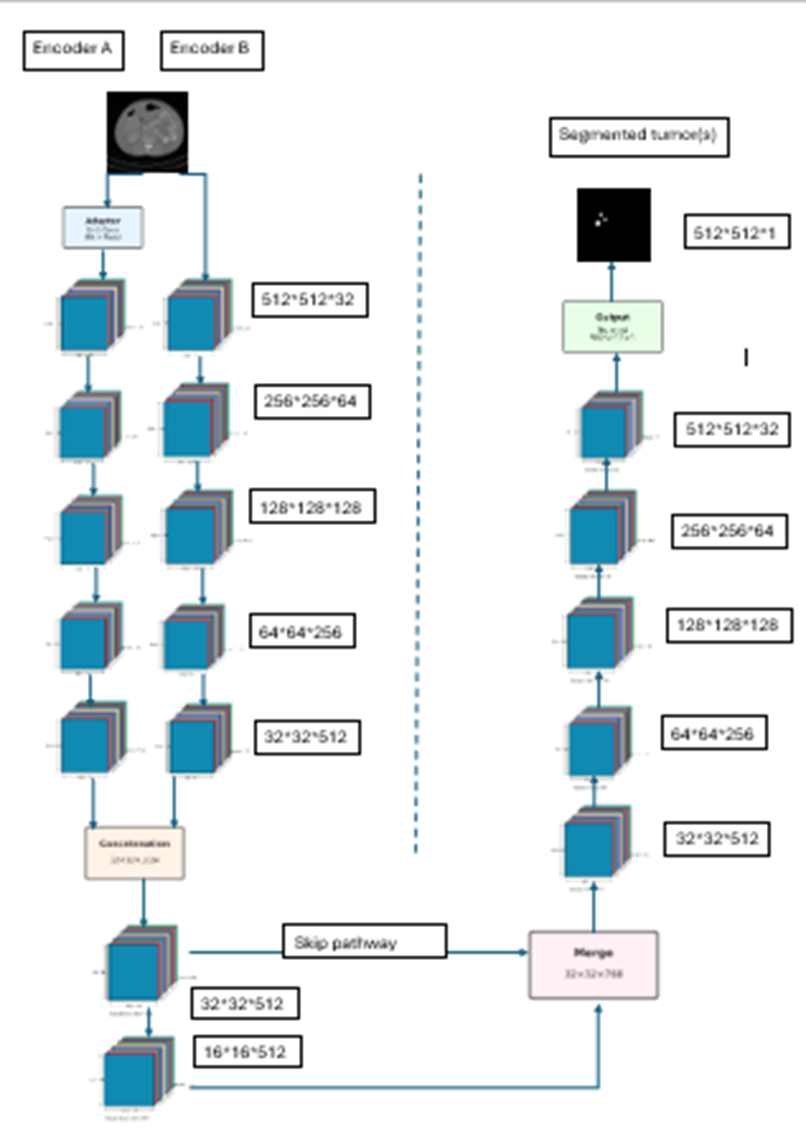

In [ ]:
# === ADEST-U-Net — Baseline-Identical Global Dice/IoU Evaluation ===
import os, cv2, gc, numpy as np, tensorflow as tf, importlib.util
from tensorflow.keras.models import load_model

# ------------------- EDIT THESE -------------------
MODEL_PATH = "/content/drive/MyDrive/track3/dual_encoder_sharedtail_adapted_trained_dropout0.3_lrSched (1).h5"
ARCH_PATH  = "/content/drive/MyDrive/track3/dual_encoder_with_shared_tail_adapted (1).py"  # used only if direct load fails
IMG_DIR    = "/content/drive/MyDrive/final_split_balanced/final_split_balanced/test/images"
MASK_DIR   = "/content/drive/MyDrive/final_split_balanced/final_split_balanced/test/masks"
# --------------------------------------------------

IMG_SIZE = 512
THRESH   = 0.5
BATCH    = 2

# Optional: GPU memory growth
for g in tf.config.list_physical_devices("GPU"):
    try: tf.config.experimental.set_memory_growth(g, True)
    except: pass

def build_arch_from_file(arch_path, input_shape=(IMG_SIZE, IMG_SIZE, 1)):
    spec = importlib.util.spec_from_file_location("dual_mod", arch_path)
    dual_mod = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(dual_mod)
    return dual_mod.build_dual_encoder_with_shared_tail_adapted(
        input_shape=input_shape, filters=[32,64,128,256,512], dropout_rate=0.3
    )

def load_model_safely(model_path, arch_path):
    try:
        m = load_model(model_path, compile=False)
        return m
    except Exception:
        m = build_arch_from_file(arch_path)
        m.load_weights(model_path, by_name=True, skip_mismatch=True)
        return m

# ---- Collect filenames exactly like baseline ----
image_ids = sorted([f for f in os.listdir(IMG_DIR)
                    if f.lower().endswith(".png") and os.path.exists(os.path.join(MASK_DIR, f))])
print(f"Found {len(image_ids)} image/mask pairs.")

# ---- Load images & masks (baseline style) ----
images, masks = [], []
for img_id in image_ids:
    img = cv2.imread(os.path.join(IMG_DIR, img_id), cv2.IMREAD_GRAYSCALE).astype(np.float32) / 255.0
    msk = cv2.imread(os.path.join(MASK_DIR, img_id), cv2.IMREAD_GRAYSCALE).astype(np.float32)

    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_LINEAR)
    msk = cv2.resize(msk, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST)

    msk = (msk >= 255).astype(np.float32)  # exact baseline binarization

    images.append(np.expand_dims(img, axis=-1))
    masks.append(np.expand_dims(msk, axis=-1))

images = np.array(images, dtype=np.float32)   # (N,512,512,1)
masks  = np.array(masks,  dtype=np.float32)   # (N,512,512,1)

# ---- Load model & predict ----
model = load_model_safely(MODEL_PATH, ARCH_PATH)
preds = model.predict(images, batch_size=BATCH, verbose=1)  # (N, H, W, 1) or (N, H, W)

# Ensure (N,512,512)
if preds.ndim == 4:
    preds = preds[..., 0]  # (N,H,W)
elif preds.ndim != 3:
    raise ValueError(f"Unexpected preds shape: {preds.shape}")

if preds.shape[1] != IMG_SIZE or preds.shape[2] != IMG_SIZE:
    preds = np.stack([cv2.resize(p, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST) for p in preds], axis=0)

preds_bin = (preds > THRESH).astype(np.float32)      # (N,512,512)
preds_bin = preds_bin[..., np.newaxis]               # (N,512,512,1) to match masks

# ---- Global (micro) Dice/IoU — identical to baseline ----
def dice_score(y_true, y_pred, smooth=1e-6):
    inter = np.sum(y_true * y_pred)
    return (2.0 * inter) / (np.sum(y_true) + np.sum(y_pred) + smooth)

def iou_score(y_true, y_pred, smooth=1e-6):
    inter = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred) - inter
    return (inter + smooth) / (union + smooth)

overall_dice = dice_score(masks, preds_bin)
overall_iou  = iou_score(masks, preds_bin)

print(f"\nOverall Dice Score : {overall_dice:.4f}")
print(f"Overall IoU Score : {overall_iou:.4f}")

gc.collect()


Found 57 image/mask pairs.
29/29 ━━━━━━━━━━━━━━━━━━━━ 121s 4s/step

Overall Dice Score (micro): 0.7189
Overall IoU Score  (micro): 0.5611


4644

In [3]:
# === ADEST-U-Net — Baseline-Identical Global Dice/IoU Evaluation ===
import os, cv2, gc, numpy as np, tensorflow as tf, importlib.util
from tensorflow.keras.models import load_model

# ------------------- EDIT THESE -------------------
MODEL_PATH = "/content/drive/MyDrive/track3/dual_encoder_sharedtail_adapted_trained_dropout0.3_lrSched (1).h5"
ARCH_PATH  = "/content/drive/MyDrive/track3/dual_encoder_with_shared_tail_adapted (1).py"  # used only if direct load fails
IMG_DIR    = "/content/drive/MyDrive/final_split_balanced/final_split_balanced/valid/images"
MASK_DIR   = "/content/drive/MyDrive/final_split_balanced/final_split_balanced/valid/masks"
# --------------------------------------------------

IMG_SIZE = 512
THRESH   = 0.5
BATCH    = 2

# Optional: GPU memory growth
for g in tf.config.list_physical_devices("GPU"):
    try: tf.config.experimental.set_memory_growth(g, True)
    except: pass

def build_arch_from_file(arch_path, input_shape=(IMG_SIZE, IMG_SIZE, 1)):
    spec = importlib.util.spec_from_file_location("dual_mod", arch_path)
    dual_mod = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(dual_mod)
    return dual_mod.build_dual_encoder_with_shared_tail_adapted(
        input_shape=input_shape, filters=[32,64,128,256,512], dropout_rate=0.3
    )

def load_model_safely(model_path, arch_path):
    try:
        m = load_model(model_path, compile=False)
        return m
    except Exception:
        m = build_arch_from_file(arch_path)
        m.load_weights(model_path, by_name=True, skip_mismatch=True)
        return m

# ---- Collect filenames exactly like baseline ----
image_ids = sorted([f for f in os.listdir(IMG_DIR)
                    if f.lower().endswith(".png") and os.path.exists(os.path.join(MASK_DIR, f))])
print(f"Found {len(image_ids)} image/mask pairs.")

# ---- Load images & masks (baseline style) ----
images, masks = [], []
for img_id in image_ids:
    img = cv2.imread(os.path.join(IMG_DIR, img_id), cv2.IMREAD_GRAYSCALE).astype(np.float32) / 255.0
    msk = cv2.imread(os.path.join(MASK_DIR, img_id), cv2.IMREAD_GRAYSCALE).astype(np.float32)

    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_LINEAR)
    msk = cv2.resize(msk, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST)

    msk = (msk >= 255).astype(np.float32)  # exact baseline binarization

    images.append(np.expand_dims(img, axis=-1))
    masks.append(np.expand_dims(msk, axis=-1))

images = np.array(images, dtype=np.float32)   # (N,512,512,1)
masks  = np.array(masks,  dtype=np.float32)   # (N,512,512,1)

# ---- Load model & predict ----
model = load_model_safely(MODEL_PATH, ARCH_PATH)
preds = model.predict(images, batch_size=BATCH, verbose=1)  # (N, H, W, 1) or (N, H, W)

# Ensure (N,512,512)
if preds.ndim == 4:
    preds = preds[..., 0]  # (N,H,W)
elif preds.ndim != 3:
    raise ValueError(f"Unexpected preds shape: {preds.shape}")

if preds.shape[1] != IMG_SIZE or preds.shape[2] != IMG_SIZE:
    preds = np.stack([cv2.resize(p, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST) for p in preds], axis=0)

preds_bin = (preds > THRESH).astype(np.float32)      # (N,512,512)
preds_bin = preds_bin[..., np.newaxis]               # (N,512,512,1) to match masks

# ---- Global (micro) Dice/IoU — identical to baseline ----
def dice_score(y_true, y_pred, smooth=1e-6):
    inter = np.sum(y_true * y_pred)
    return (2.0 * inter) / (np.sum(y_true) + np.sum(y_pred) + smooth)

def iou_score(y_true, y_pred, smooth=1e-6):
    inter = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred) - inter
    return (inter + smooth) / (union + smooth)

overall_dice = dice_score(masks, preds_bin)
overall_iou  = iou_score(masks, preds_bin)

print(f"\nOverall Dice Score : {overall_dice:.4f}")
print(f"Overall IoU Score : {overall_iou:.4f}")

gc.collect()


Found 57 image/mask pairs.
29/29 ━━━━━━━━━━━━━━━━━━━━ 17s 244ms/step

Overall Dice Score : 0.7056
Overall IoU Score : 0.5451


5839

#Baseline1: Model:trained from scratch on liver CT

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import importlib.util

# === Load UNet++ Architecture ===
unetpp_path = "/content/drive/MyDrive/workspace/orkspace/UNet-Plus-Plus---Brain-Tumor-Segmentation/UNetPP.py"
spec = importlib.util.spec_from_file_location("UNetPP", unetpp_path)
unetpp_module = importlib.util.module_from_spec(spec)
spec.loader.exec_module(unetpp_module)
UNetPlusPlus = unetpp_module.UNetPlusPlus

# === Build Model and Load Weights ===
input_shape = (512, 512, 1)
model_instance = UNetPlusPlus(input_shape=input_shape)
model = model_instance.BuildNetwork()

model_path = "/content/drive/MyDrive/shape_prior_models/shape_prior_models/shapeprior_no_weigts_start_from_scratch.h5"
model.load_weights(model_path)

# === Load and Preprocess Images and Masks ===
img_dir = "/content/drive/MyDrive/final_split_balanced/final_split_balanced/test/images"
mask_dir = "/content/drive/MyDrive/final_split_balanced/final_split_balanced/test/masks"
img_size = 512

image_ids = sorted([
    f for f in os.listdir(img_dir)
    if f.endswith(".png") and os.path.exists(os.path.join(mask_dir, f))
])

images = []
masks = []

for img_id in image_ids:
    img = cv2.imread(os.path.join(img_dir, img_id), cv2.IMREAD_GRAYSCALE).astype(np.float32) / 255.0
    mask = cv2.imread(os.path.join(mask_dir, img_id), cv2.IMREAD_GRAYSCALE).astype(np.float32)
    mask = (mask >= 255).astype(np.float32)

    img = cv2.resize(img, (img_size, img_size), interpolation=cv2.INTER_LINEAR)
    mask = cv2.resize(mask, (img_size, img_size), interpolation=cv2.INTER_NEAREST)

    images.append(np.expand_dims(img, axis=-1))
    masks.append(np.expand_dims(mask, axis=-1))

images = np.array(images)
masks = np.array(masks)

# === Predict and Evaluate ===
preds = model.predict(images, batch_size=2)
preds_bin = (preds > 0.5).astype(np.float32)

def dice_score(y_true, y_pred, smooth=1e-6):
    intersection = np.sum(y_true * y_pred)
    return (2. * intersection) / (np.sum(y_true) + np.sum(y_pred) + smooth)

def iou_score(y_true, y_pred, smooth=1e-6):
    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred) - intersection
    return (intersection + smooth) / (union + smooth)

overall_dice = dice_score(masks, preds_bin)
overall_iou = iou_score(masks, preds_bin)

print(f"Overall Dice Score: {overall_dice:.4f}")
print(f"Overall IoU Score:  {overall_iou:.4f}")



29/29 ━━━━━━━━━━━━━━━━━━━━ 325s 11s/step
Overall Dice Score: 0.7020
Overall IoU Score:  0.5408


#Baseline 2: Transfer Learning with UNet++ — Pretrained on Brain MRI and Adapted to Liver CT (First Layer Frozen)

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import importlib.util

# === Load UNet++ Architecture ===
unetpp_path = "/content/drive/MyDrive/unetpp_input_adapter_ct.py"
spec = importlib.util.spec_from_file_location("UNetPP", unetpp_path)
unetpp_module = importlib.util.module_from_spec(spec)
spec.loader.exec_module(unetpp_module)
UNetPlusPlus = unetpp_module.UNetPlusPlus

# === Build Model and Load Weights ===
input_shape = (512, 512, 1)
model_instance = UNetPlusPlus(input_shape=input_shape)
model = model_instance.BuildNetwork()

model_path = "/content/drive/MyDrive/input_adapter_layers/input_adapter_layers/shapeprior_input_adapter_freeze_firstlayer.h5"
model.load_weights(model_path)

# === Load and Preprocess Images and Masks ===
img_dir = "/content/drive/MyDrive/final_split_balanced/final_split_balanced/test/images"
mask_dir = "/content/drive/MyDrive/final_split_balanced/final_split_balanced/test/masks"
img_size = 512

image_ids = sorted([
    f for f in os.listdir(img_dir)
    if f.endswith(".png") and os.path.exists(os.path.join(mask_dir, f))
])

images = []
masks = []

for img_id in image_ids:
    img = cv2.imread(os.path.join(img_dir, img_id), cv2.IMREAD_GRAYSCALE).astype(np.float32) / 255.0
    mask = cv2.imread(os.path.join(mask_dir, img_id), cv2.IMREAD_GRAYSCALE).astype(np.float32)
    mask = (mask >= 255).astype(np.float32)

    img = cv2.resize(img, (img_size, img_size), interpolation=cv2.INTER_LINEAR)
    mask = cv2.resize(mask, (img_size, img_size), interpolation=cv2.INTER_NEAREST)

    images.append(np.expand_dims(img, axis=-1))
    masks.append(np.expand_dims(mask, axis=-1))

images = np.array(images)
masks = np.array(masks)

# === Predict and Evaluate ===
preds = model.predict(images, batch_size=2)
preds_bin = (preds > 0.5).astype(np.float32)

def dice_score(y_true, y_pred, smooth=1e-6):
    intersection = np.sum(y_true * y_pred)
    return (2. * intersection) / (np.sum(y_true) + np.sum(y_pred) + smooth)

def iou_score(y_true, y_pred, smooth=1e-6):
    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred) - intersection
    return (intersection + smooth) / (union + smooth)

overall_dice = dice_score(masks, preds_bin)
overall_iou = iou_score(masks, preds_bin)

print(f"Overall Dice Score: {overall_dice:.4f}")
print(f"Overall IoU Score:  {overall_iou:.4f}")



29/29 ━━━━━━━━━━━━━━━━━━━━ 300s 10s/step
Overall Dice Score: 0.5383
Overall IoU Score:  0.3683


#validset

In [ ]:
#propsed architectue
# === ADEST-U-Net — Baseline-Identical Global Dice/IoU Evaluation ===
import os, cv2, gc, numpy as np, tensorflow as tf, importlib.util
from tensorflow.keras.models import load_model

# ------------------- EDIT THESE -------------------
MODEL_PATH = "/content/drive/MyDrive/track3/dual_encoder_sharedtail_adapted_trained_dropout0.3_lrSched (1).h5"
ARCH_PATH  = "/content/drive/MyDrive/track3/dual_encoder_with_shared_tail_adapted (1).py"  # used only if direct load fails
IMG_DIR    = "/content/drive/MyDrive/final_split_balanced/final_split_balanced/valid/images"
MASK_DIR   = "/content/drive/MyDrive/final_split_balanced/final_split_balanced/valid/masks"
# --------------------------------------------------

IMG_SIZE = 512
THRESH   = 0.5
BATCH    = 2

# Optional: GPU memory growth
for g in tf.config.list_physical_devices("GPU"):
    try: tf.config.experimental.set_memory_growth(g, True)
    except: pass

def build_arch_from_file(arch_path, input_shape=(IMG_SIZE, IMG_SIZE, 1)):
    spec = importlib.util.spec_from_file_location("dual_mod", arch_path)
    dual_mod = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(dual_mod)
    return dual_mod.build_dual_encoder_with_shared_tail_adapted(
        input_shape=input_shape, filters=[32,64,128,256,512], dropout_rate=0.3
    )

def load_model_safely(model_path, arch_path):
    try:
        m = load_model(model_path, compile=False)
        return m
    except Exception:
        m = build_arch_from_file(arch_path)
        m.load_weights(model_path, by_name=True, skip_mismatch=True)
        return m

# ---- Collect filenames exactly like baseline ----
image_ids = sorted([f for f in os.listdir(IMG_DIR)
                    if f.lower().endswith(".png") and os.path.exists(os.path.join(MASK_DIR, f))])
print(f"Found {len(image_ids)} image/mask pairs.")

# ---- Load images & masks (baseline style) ----
images, masks = [], []
for img_id in image_ids:
    img = cv2.imread(os.path.join(IMG_DIR, img_id), cv2.IMREAD_GRAYSCALE).astype(np.float32) / 255.0
    msk = cv2.imread(os.path.join(MASK_DIR, img_id), cv2.IMREAD_GRAYSCALE).astype(np.float32)

    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_LINEAR)
    msk = cv2.resize(msk, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST)

    msk = (msk >= 255).astype(np.float32)  # exact baseline binarization

    images.append(np.expand_dims(img, axis=-1))
    masks.append(np.expand_dims(msk, axis=-1))

images = np.array(images, dtype=np.float32)   # (N,512,512,1)
masks  = np.array(masks,  dtype=np.float32)   # (N,512,512,1)

# ---- Load model & predict ----
model = load_model_safely(MODEL_PATH, ARCH_PATH)
preds = model.predict(images, batch_size=BATCH, verbose=1)  # (N, H, W, 1) or (N, H, W)

# Ensure (N,512,512)
if preds.ndim == 4:
    preds = preds[..., 0]  # (N,H,W)
elif preds.ndim != 3:
    raise ValueError(f"Unexpected preds shape: {preds.shape}")

if preds.shape[1] != IMG_SIZE or preds.shape[2] != IMG_SIZE:
    preds = np.stack([cv2.resize(p, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST) for p in preds], axis=0)

preds_bin = (preds > THRESH).astype(np.float32)      # (N,512,512)
preds_bin = preds_bin[..., np.newaxis]               # (N,512,512,1) to match masks

# ---- Global (micro) Dice/IoU — identical to baseline ----
def dice_score(y_true, y_pred, smooth=1e-6):
    inter = np.sum(y_true * y_pred)
    return (2.0 * inter) / (np.sum(y_true) + np.sum(y_pred) + smooth)

def iou_score(y_true, y_pred, smooth=1e-6):
    inter = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred) - inter
    return (inter + smooth) / (union + smooth)

overall_dice = dice_score(masks, preds_bin)
overall_iou  = iou_score(masks, preds_bin)

print(f"\nOverall Dice Score : {overall_dice:.4f}")
print(f"Overall IoU Score : {overall_iou:.4f}")

gc.collect()


Found 57 image/mask pairs.
29/29 ━━━━━━━━━━━━━━━━━━━━ 17s 249ms/step

Overall Dice Score : 0.7056
Overall IoU Score : 0.5451


4644

In [ ]:
#baseline1
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import importlib.util

# === Load UNet++ Architecture ===
unetpp_path = "/content/drive/MyDrive/workspace/orkspace/UNet-Plus-Plus---Brain-Tumor-Segmentation/UNetPP.py"
spec = importlib.util.spec_from_file_location("UNetPP", unetpp_path)
unetpp_module = importlib.util.module_from_spec(spec)
spec.loader.exec_module(unetpp_module)
UNetPlusPlus = unetpp_module.UNetPlusPlus

# === Build Model and Load Weights ===
input_shape = (512, 512, 1)
model_instance = UNetPlusPlus(input_shape=input_shape)
model = model_instance.BuildNetwork()

model_path = "/content/drive/MyDrive/shape_prior_models/shape_prior_models/shapeprior_no_weigts_start_from_scratch.h5"
model.load_weights(model_path)

# === Load and Preprocess Images and Masks ===
img_dir = "/content/drive/MyDrive/final_split_balanced/final_split_balanced/valid/images"
mask_dir = "/content/drive/MyDrive/final_split_balanced/final_split_balanced/valid/masks"
img_size = 512

image_ids = sorted([
    f for f in os.listdir(img_dir)
    if f.endswith(".png") and os.path.exists(os.path.join(mask_dir, f))
])

images = []
masks = []

for img_id in image_ids:
    img = cv2.imread(os.path.join(img_dir, img_id), cv2.IMREAD_GRAYSCALE).astype(np.float32) / 255.0
    mask = cv2.imread(os.path.join(mask_dir, img_id), cv2.IMREAD_GRAYSCALE).astype(np.float32)
    mask = (mask >= 255).astype(np.float32)

    img = cv2.resize(img, (img_size, img_size), interpolation=cv2.INTER_LINEAR)
    mask = cv2.resize(mask, (img_size, img_size), interpolation=cv2.INTER_NEAREST)

    images.append(np.expand_dims(img, axis=-1))
    masks.append(np.expand_dims(mask, axis=-1))

images = np.array(images)
masks = np.array(masks)

# === Predict and Evaluate ===
preds = model.predict(images, batch_size=2)
preds_bin = (preds > 0.5).astype(np.float32)

def dice_score(y_true, y_pred, smooth=1e-6):
    intersection = np.sum(y_true * y_pred)
    return (2. * intersection) / (np.sum(y_true) + np.sum(y_pred) + smooth)

def iou_score(y_true, y_pred, smooth=1e-6):
    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred) - intersection
    return (intersection + smooth) / (union + smooth)

overall_dice = dice_score(masks, preds_bin)
overall_iou = iou_score(masks, preds_bin)

print(f"Overall Dice Score: {overall_dice:.4f}")
print(f"Overall IoU Score:  {overall_iou:.4f}")



29/29 ━━━━━━━━━━━━━━━━━━━━ 309s 11s/step
Overall Dice Score: 0.5879
Overall IoU Score:  0.4163


In [ ]:
#BAseline2:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import importlib.util

# === Load UNet++ Architecture ===
unetpp_path = "/content/drive/MyDrive/unetpp_input_adapter_ct.py"
spec = importlib.util.spec_from_file_location("UNetPP", unetpp_path)
unetpp_module = importlib.util.module_from_spec(spec)
spec.loader.exec_module(unetpp_module)
UNetPlusPlus = unetpp_module.UNetPlusPlus

# === Build Model and Load Weights ===
input_shape = (512, 512, 1)
model_instance = UNetPlusPlus(input_shape=input_shape)
model = model_instance.BuildNetwork()

model_path = "/content/drive/MyDrive/input_adapter_layers/input_adapter_layers/shapeprior_input_adapter_freeze_firstlayer.h5"
model.load_weights(model_path)

# === Load and Preprocess Images and Masks ===
img_dir = "/content/drive/MyDrive/final_split_balanced/final_split_balanced/valid/images"
mask_dir = "/content/drive/MyDrive/final_split_balanced/final_split_balanced/valid/masks"
img_size = 512

image_ids = sorted([
    f for f in os.listdir(img_dir)
    if f.endswith(".png") and os.path.exists(os.path.join(mask_dir, f))
])

images = []
masks = []

for img_id in image_ids:
    img = cv2.imread(os.path.join(img_dir, img_id), cv2.IMREAD_GRAYSCALE).astype(np.float32) / 255.0
    mask = cv2.imread(os.path.join(mask_dir, img_id), cv2.IMREAD_GRAYSCALE).astype(np.float32)
    mask = (mask >= 255).astype(np.float32)

    img = cv2.resize(img, (img_size, img_size), interpolation=cv2.INTER_LINEAR)
    mask = cv2.resize(mask, (img_size, img_size), interpolation=cv2.INTER_NEAREST)

    images.append(np.expand_dims(img, axis=-1))
    masks.append(np.expand_dims(mask, axis=-1))

images = np.array(images)
masks = np.array(masks)

# === Predict and Evaluate ===
preds = model.predict(images, batch_size=2)
preds_bin = (preds > 0.5).astype(np.float32)

def dice_score(y_true, y_pred, smooth=1e-6):
    intersection = np.sum(y_true * y_pred)
    return (2. * intersection) / (np.sum(y_true) + np.sum(y_pred) + smooth)

def iou_score(y_true, y_pred, smooth=1e-6):
    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred) - intersection
    return (intersection + smooth) / (union + smooth)

overall_dice = dice_score(masks, preds_bin)
overall_iou = iou_score(masks, preds_bin)

print(f"Overall Dice Score: {overall_dice:.4f}")
print(f"Overall IoU Score:  {overall_iou:.4f}")



29/29 ━━━━━━━━━━━━━━━━━━━━ 33s 505ms/step
Overall Dice Score: 0.4794
Overall IoU Score:  0.3153


#SQUH dataset

#testset

In [ ]:
# ==== Dual-Encoder (Adapted) — CT | GT | Pred (pred = white on black), 512-metrics only ====
import os, importlib.util, numpy as np, tensorflow as tf, cv2, gc
from tensorflow.keras.models import load_model, Model
from tensorflow.keras import layers
import matplotlib.pyplot as plt

# ------------------- EDIT THESE -------------------
MODEL_PATH = "/content/drive/MyDrive/track3/dual_encoder_sharedtail_adapted_trained_dropout0.3_lrSched (1).h5"
ARCH_PATH  = "/content/drive/MyDrive/track3/dual_encoder_with_shared_tail_adapted (1).py"
IMG_DIR    = "/content/drive/MyDrive/SQU_split_tumor_80_10_10/test/images"
MASK_DIR   = "/content/drive/MyDrive/SQU_split_tumor_80_10_10/test/masks"
# --------------------------------------------------

img_size   = 512
BATCH_SIZE = 8
THRESH     = 0.5
NORMALIZE  = "scale255"   # match training

# GPU memory growth
for g in tf.config.list_physical_devices("GPU"):
    try: tf.config.experimental.set_memory_growth(g, True)
    except: pass

def build_arch_from_file(arch_path, input_shape=(img_size, img_size, 1)):
    spec = importlib.util.spec_from_file_location("dual_mod", arch_path)
    dual_mod = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(dual_mod)
    return dual_mod.build_dual_encoder_with_shared_tail_adapted(
        input_shape=input_shape, filters=[32,64,128,256,512], dropout_rate=0.3
    )

def load_model_safely(model_path, arch_path):
    try:
        m = load_model(model_path, compile=False)
        return m
    except Exception:
        m = build_arch_from_file(arch_path)
        m.load_weights(model_path, by_name=True, skip_mismatch=True)
        return m

# ---- preprocessing ----
def normalize_img(img):
    if NORMALIZE == "scale255":
        img = img / 255.0
    elif NORMALIZE == "zscore":
        img = img / 255.0
        mu, sd = img.mean(), img.std()
        img = (img - mu) / (sd if sd > 1e-6 else 1e-6)
    elif NORMALIZE == "minmax":
        mn, mx = img.min(), img.max()
        img = (img - mn) / (mx - mn + 1e-6) if mx > mn else np.zeros_like(img)
    else:
        img = img / 255.0
    return img

def load_gray_exact(path, size):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE).astype(np.float32)
    img = normalize_img(img)
    img = cv2.resize(img, (size, size), interpolation=cv2.INTER_LINEAR)
    return np.expand_dims(img, axis=-1)

def load_mask_exact(path, size):
    mask = cv2.imread(path, cv2.IMREAD_GRAYSCALE).astype(np.float32)
    mask = cv2.resize(mask, (size, size), interpolation=cv2.INTER_NEAREST)
    mask = (mask >= 255).astype(np.float32)
    return np.expand_dims(mask, axis=-1)

def show_triptych(ct, gt, pred_bin, fname=""):
    fig = plt.figure(figsize=(9,3))
    ax1 = plt.subplot(1,3,1); ax1.imshow(ct[...,0], cmap="gray"); ax1.set_title("CT"); ax1.axis("off")
    ax2 = plt.subplot(1,3,2); ax2.imshow(gt[...,0], cmap="gray", vmin=0, vmax=1); ax2.set_title("GT"); ax2.axis("off")
    ax3 = plt.subplot(1,3,3); ax3.imshow(pred_bin, cmap="gray", vmin=0, vmax=1); ax3.set_title("Pred"); ax3.axis("off")
    if fname: plt.suptitle(fname)
    plt.tight_layout(); plt.show(); plt.close(fig)

# ---- load model and 256->512 wrapper ----
base = load_model_safely(MODEL_PATH, ARCH_PATH)
pred512_layer = layers.Resizing(img_size, img_size, interpolation="nearest", name="resize_to_512")(base.output)
wrapped = Model(inputs=base.input, outputs=pred512_layer, name=base.name + "_upsampled512")
wrapped.trainable = False

# ---- collect test pairs ----
files = sorted([f for f in os.listdir(IMG_DIR) if os.path.isfile(os.path.join(IMG_DIR, f))])
pairs = [(os.path.join(IMG_DIR, f), os.path.join(MASK_DIR, f)) for f in files if os.path.exists(os.path.join(MASK_DIR, f))]
print(f"Found {len(pairs)} image/mask pairs.")

# ---- micro accumulators ----
all_inter, all_pred, all_true = 0, 0, 0

# ---- inference loop ----
for i in range(0, len(pairs), BATCH_SIZE):
    batch = pairs[i:i+BATCH_SIZE]
    imgs  = [load_gray_exact(ip, img_size) for ip, _ in batch]
    msks  = [load_mask_exact(mp, img_size) for _, mp in batch]
    x     = np.array(imgs, dtype=np.float32)

    preds = wrapped.predict(x, verbose=0)[..., 0]  # (B,512,512)

    for j, (ip, mp) in enumerate(batch):
        pb  = (preds[j] >= THRESH).astype(np.float32)  # binary
        gt  = msks[j][...,0]

        # accumulate for micro metrics
        inter = np.sum(gt * pb)
        all_inter += inter
        all_true  += np.sum(gt)
        all_pred  += np.sum(pb)

        # visualize sample
        show_triptych(imgs[j], msks[j], pb, fname=os.path.basename(ip))

    del imgs, msks, x, preds
    gc.collect()

# ---- final micro Dice/IoU ----
smooth = 1e-6
micro_dice = (2*all_inter + smooth) / (all_true + all_pred + smooth)
micro_iou  = (all_inter + smooth) / (all_true + all_pred - all_inter + smooth)

print(f"\nOverall Dice Score : {micro_dice:.4f}")
print(f"Overall IoU Score  : {micro_iou:.4f}")


Output hidden; open in https://colab.research.google.com to view.

\#valid

In [ ]:
# ==== Dual-Encoder (Adapted) — CT | GT | Pred (pred = white on black), 512-metrics only ====
import os, importlib.util, numpy as np, tensorflow as tf, cv2, gc
from tensorflow.keras.models import load_model, Model
from tensorflow.keras import layers
import matplotlib.pyplot as plt

# ------------------- EDIT THESE -------------------
MODEL_PATH = "/content/drive/MyDrive/track3/dual_encoder_sharedtail_adapted_trained_dropout0.3_lrSched (1).h5"
ARCH_PATH  = "/content/drive/MyDrive/track3/dual_encoder_with_shared_tail_adapted (1).py"
IMG_DIR    = "/content/drive/MyDrive/SQU_split_tumor_80_10_10/val/images"
MASK_DIR   = "/content/drive/MyDrive/SQU_split_tumor_80_10_10/val/masks"
# --------------------------------------------------

img_size   = 512
BATCH_SIZE = 8
THRESH     = 0.5
NORMALIZE  = "scale255"   # match training

# GPU memory growth
for g in tf.config.list_physical_devices("GPU"):
    try: tf.config.experimental.set_memory_growth(g, True)
    except: pass

def build_arch_from_file(arch_path, input_shape=(img_size, img_size, 1)):
    spec = importlib.util.spec_from_file_location("dual_mod", arch_path)
    dual_mod = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(dual_mod)
    return dual_mod.build_dual_encoder_with_shared_tail_adapted(
        input_shape=input_shape, filters=[32,64,128,256,512], dropout_rate=0.3
    )

def load_model_safely(model_path, arch_path):
    try:
        m = load_model(model_path, compile=False)
        return m
    except Exception:
        m = build_arch_from_file(arch_path)
        m.load_weights(model_path, by_name=True, skip_mismatch=True)
        return m

# ---- preprocessing ----
def normalize_img(img):
    if NORMALIZE == "scale255":
        img = img / 255.0
    elif NORMALIZE == "zscore":
        img = img / 255.0
        mu, sd = img.mean(), img.std()
        img = (img - mu) / (sd if sd > 1e-6 else 1e-6)
    elif NORMALIZE == "minmax":
        mn, mx = img.min(), img.max()
        img = (img - mn) / (mx - mn + 1e-6) if mx > mn else np.zeros_like(img)
    else:
        img = img / 255.0
    return img

def load_gray_exact(path, size):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE).astype(np.float32)
    img = normalize_img(img)
    img = cv2.resize(img, (size, size), interpolation=cv2.INTER_LINEAR)
    return np.expand_dims(img, axis=-1)

def load_mask_exact(path, size):
    mask = cv2.imread(path, cv2.IMREAD_GRAYSCALE).astype(np.float32)
    mask = cv2.resize(mask, (size, size), interpolation=cv2.INTER_NEAREST)
    mask = (mask >= 255).astype(np.float32)
    return np.expand_dims(mask, axis=-1)

def show_triptych(ct, gt, pred_bin, fname=""):
    fig = plt.figure(figsize=(9,3))
    ax1 = plt.subplot(1,3,1); ax1.imshow(ct[...,0], cmap="gray"); ax1.set_title("CT"); ax1.axis("off")
    ax2 = plt.subplot(1,3,2); ax2.imshow(gt[...,0], cmap="gray", vmin=0, vmax=1); ax2.set_title("GT"); ax2.axis("off")
    ax3 = plt.subplot(1,3,3); ax3.imshow(pred_bin, cmap="gray", vmin=0, vmax=1); ax3.set_title("Pred"); ax3.axis("off")
    if fname: plt.suptitle(fname)
    plt.tight_layout(); plt.show(); plt.close(fig)

# ---- load model and 256->512 wrapper ----
base = load_model_safely(MODEL_PATH, ARCH_PATH)
pred512_layer = layers.Resizing(img_size, img_size, interpolation="nearest", name="resize_to_512")(base.output)
wrapped = Model(inputs=base.input, outputs=pred512_layer, name=base.name + "_upsampled512")
wrapped.trainable = False

# ---- collect test pairs ----
files = sorted([f for f in os.listdir(IMG_DIR) if os.path.isfile(os.path.join(IMG_DIR, f))])
pairs = [(os.path.join(IMG_DIR, f), os.path.join(MASK_DIR, f)) for f in files if os.path.exists(os.path.join(MASK_DIR, f))]
print(f"Found {len(pairs)} image/mask pairs.")

# ---- micro accumulators ----
all_inter, all_pred, all_true = 0, 0, 0

# ---- inference loop ----
for i in range(0, len(pairs), BATCH_SIZE):
    batch = pairs[i:i+BATCH_SIZE]
    imgs  = [load_gray_exact(ip, img_size) for ip, _ in batch]
    msks  = [load_mask_exact(mp, img_size) for _, mp in batch]
    x     = np.array(imgs, dtype=np.float32)

    preds = wrapped.predict(x, verbose=0)[..., 0]  # (B,512,512)

    for j, (ip, mp) in enumerate(batch):
        pb  = (preds[j] >= THRESH).astype(np.float32)  # binary
        gt  = msks[j][...,0]

        # accumulate for micro metrics
        inter = np.sum(gt * pb)
        all_inter += inter
        all_true  += np.sum(gt)
        all_pred  += np.sum(pb)

        # visualize sample
        show_triptych(imgs[j], msks[j], pb, fname=os.path.basename(ip))

    del imgs, msks, x, preds
    gc.collect()

# ---- final micro Dice/IoU ----
smooth = 1e-6
micro_dice = (2*all_inter + smooth) / (all_true + all_pred + smooth)
micro_iou  = (all_inter + smooth) / (all_true + all_pred - all_inter + smooth)

print(f"\nOverall Dice Score : {micro_dice:.4f}")
print(f"Overall IoU Score  : {micro_iou:.4f}")


Output hidden; open in https://colab.research.google.com to view.

#Baseline1

In [ ]:
#finetube lambda point 2#
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import importlib.util

# === Load UNet++ Architecture ===
unetpp_path = "/content/drive/MyDrive/workspace/orkspace/UNet-Plus-Plus---Brain-Tumor-Segmentation/UNetPP.py"
spec = importlib.util.spec_from_file_location("UNetPP", unetpp_path)
unetpp_module = importlib.util.module_from_spec(spec)
spec.loader.exec_module(unetpp_module)
UNetPlusPlus = unetpp_module.UNetPlusPlus

# === Build Model and Load Weights ===
input_shape = (512, 512, 1)
model_instance = UNetPlusPlus(input_shape=input_shape)
model = model_instance.BuildNetwork()

model_path = "/content/drive/MyDrive/shape_prior_models/shape_prior_models/shapeprior_no_weigts_start_from_scratch.h5"
model.load_weights(model_path)

# === Load and Preprocess Images and Masks ===
img_dir = "/content/drive/MyDrive/SQU_split_tumor_80_10_10/test/images"
mask_dir = "/content/drive/MyDrive/SQU_split_tumor_80_10_10/test/masks"
img_size = 512

image_ids = sorted([
    f for f in os.listdir(img_dir)
    if f.endswith(".png") and os.path.exists(os.path.join(mask_dir, f))
])

images = []
masks = []

for img_id in image_ids:
    img = cv2.imread(os.path.join(img_dir, img_id), cv2.IMREAD_GRAYSCALE).astype(np.float32) / 255.0
    mask = cv2.imread(os.path.join(mask_dir, img_id), cv2.IMREAD_GRAYSCALE).astype(np.float32)
    mask = (mask >= 255).astype(np.float32)

    img = cv2.resize(img, (img_size, img_size), interpolation=cv2.INTER_LINEAR)
    mask = cv2.resize(mask, (img_size, img_size), interpolation=cv2.INTER_NEAREST)

    images.append(np.expand_dims(img, axis=-1))
    masks.append(np.expand_dims(mask, axis=-1))

images = np.array(images)
masks = np.array(masks)

# === Predict and Evaluate ===
preds = model.predict(images, batch_size=2)
preds_bin = (preds > 0.5).astype(np.float32)

def dice_score(y_true, y_pred, smooth=1e-6):
    intersection = np.sum(y_true * y_pred)
    return (2. * intersection) / (np.sum(y_true) + np.sum(y_pred) + smooth)

def iou_score(y_true, y_pred, smooth=1e-6):
    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred) - intersection
    return (intersection + smooth) / (union + smooth)

overall_dice = dice_score(masks, preds_bin)
overall_iou = iou_score(masks, preds_bin)

print(f"Overall Dice Score: {overall_dice:.4f}")
print(f"Overall IoU Score:  {overall_iou:.4f}")

# === Visualize All Results ===
for i in range(len(images)):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(images[i].squeeze(), cmap='gray')
    plt.title(f"Image {i+1}")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(masks[i].squeeze(), cmap='gray')
    plt.title("Ground Truth")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(preds_bin[i].squeeze(), cmap='gray')
    plt.title("Prediction")
    plt.axis('off')

    plt.tight_layout()
    plt.show()



Output hidden; open in https://colab.research.google.com to view.

In [ ]:
#finetube lambda point 2#
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import importlib.util

# === Load UNet++ Architecture ===
unetpp_path = "/content/drive/MyDrive/workspace/orkspace/UNet-Plus-Plus---Brain-Tumor-Segmentation/UNetPP.py"
spec = importlib.util.spec_from_file_location("UNetPP", unetpp_path)
unetpp_module = importlib.util.module_from_spec(spec)
spec.loader.exec_module(unetpp_module)
UNetPlusPlus = unetpp_module.UNetPlusPlus

# === Build Model and Load Weights ===
input_shape = (512, 512, 1)
model_instance = UNetPlusPlus(input_shape=input_shape)
model = model_instance.BuildNetwork()

model_path = "/content/drive/MyDrive/shape_prior_models/shape_prior_models/shapeprior_no_weigts_start_from_scratch.h5"
model.load_weights(model_path)

# === Load and Preprocess Images and Masks ===
img_dir = "/content/drive/MyDrive/SQU_split_tumor_80_10_10/val/images"
mask_dir = "/content/drive/MyDrive/SQU_split_tumor_80_10_10/val/masks"
img_size = 512

image_ids = sorted([
    f for f in os.listdir(img_dir)
    if f.endswith(".png") and os.path.exists(os.path.join(mask_dir, f))
])

images = []
masks = []

for img_id in image_ids:
    img = cv2.imread(os.path.join(img_dir, img_id), cv2.IMREAD_GRAYSCALE).astype(np.float32) / 255.0
    mask = cv2.imread(os.path.join(mask_dir, img_id), cv2.IMREAD_GRAYSCALE).astype(np.float32)
    mask = (mask >= 255).astype(np.float32)

    img = cv2.resize(img, (img_size, img_size), interpolation=cv2.INTER_LINEAR)
    mask = cv2.resize(mask, (img_size, img_size), interpolation=cv2.INTER_NEAREST)

    images.append(np.expand_dims(img, axis=-1))
    masks.append(np.expand_dims(mask, axis=-1))

images = np.array(images)
masks = np.array(masks)

# === Predict and Evaluate ===
preds = model.predict(images, batch_size=2)
preds_bin = (preds > 0.5).astype(np.float32)

def dice_score(y_true, y_pred, smooth=1e-6):
    intersection = np.sum(y_true * y_pred)
    return (2. * intersection) / (np.sum(y_true) + np.sum(y_pred) + smooth)

def iou_score(y_true, y_pred, smooth=1e-6):
    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred) - intersection
    return (intersection + smooth) / (union + smooth)

overall_dice = dice_score(masks, preds_bin)
overall_iou = iou_score(masks, preds_bin)

print(f"Overall Dice Score: {overall_dice:.4f}")
print(f"Overall IoU Score:  {overall_iou:.4f}")

# === Visualize All Results ===
for i in range(len(images)):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(images[i].squeeze(), cmap='gray')
    plt.title(f"Image {i+1}")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(masks[i].squeeze(), cmap='gray')
    plt.title("Ground Truth")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(preds_bin[i].squeeze(), cmap='gray')
    plt.title("Prediction")
    plt.axis('off')

    plt.tight_layout()
    plt.show()



Output hidden; open in https://colab.research.google.com to view.

#Baseline 2

70/70 ━━━━━━━━━━━━━━━━━━━━ 9s 103ms/step
preds_prob shape: (140, 512, 512, 1)
preds_prob range: min = 0.5 max = 0.7310585379600525
Overall Dice Score: 0.0103
Overall IoU Score : 0.0052


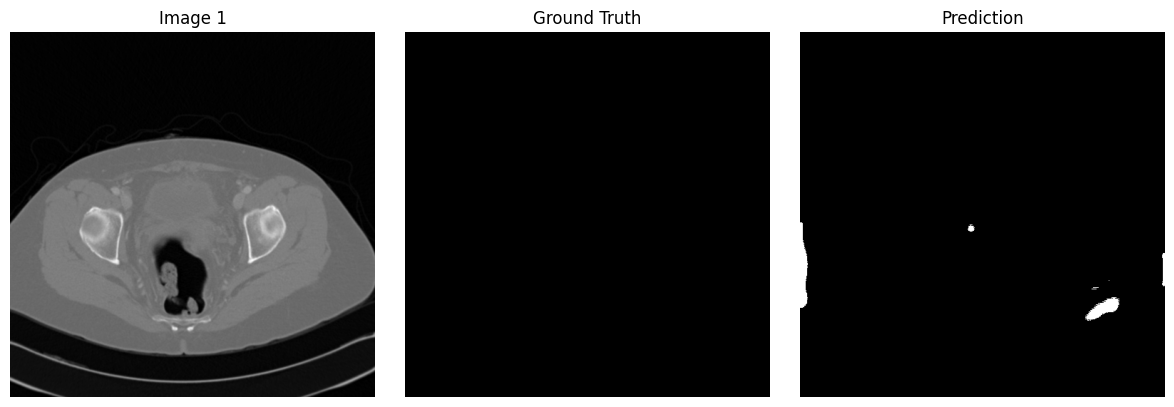

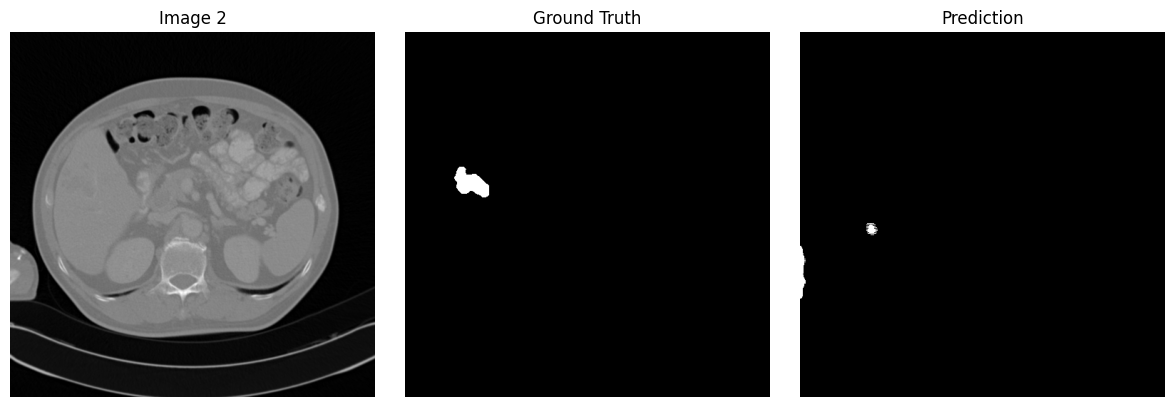

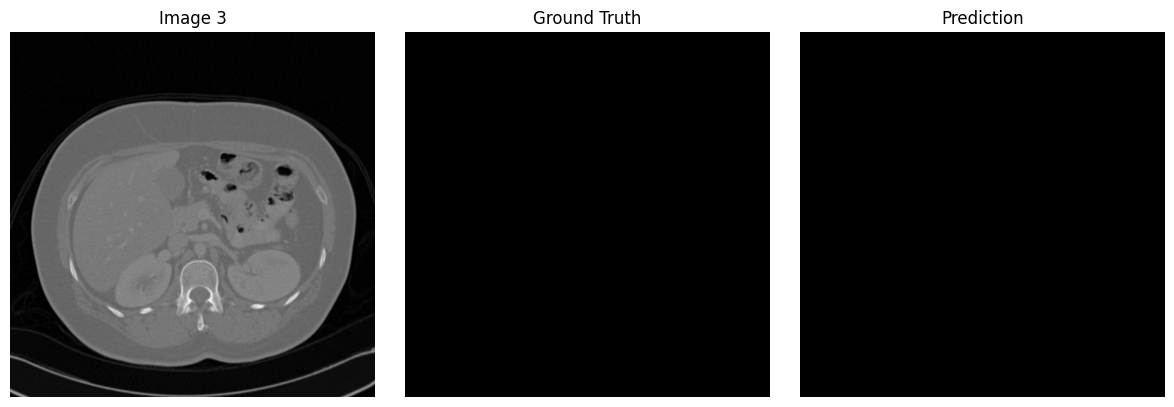

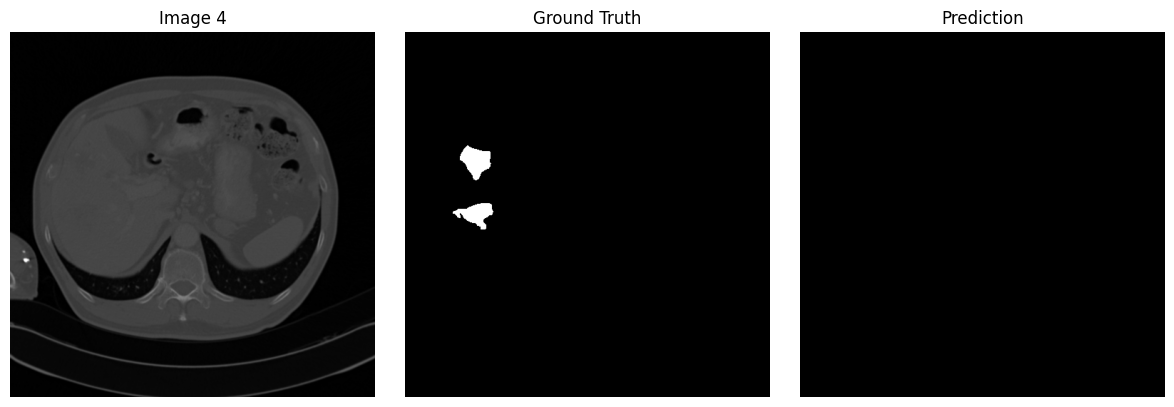

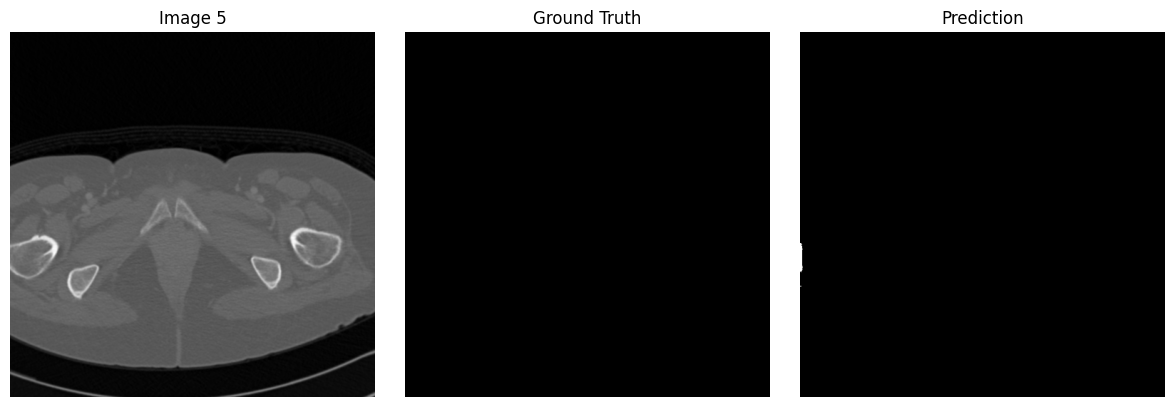

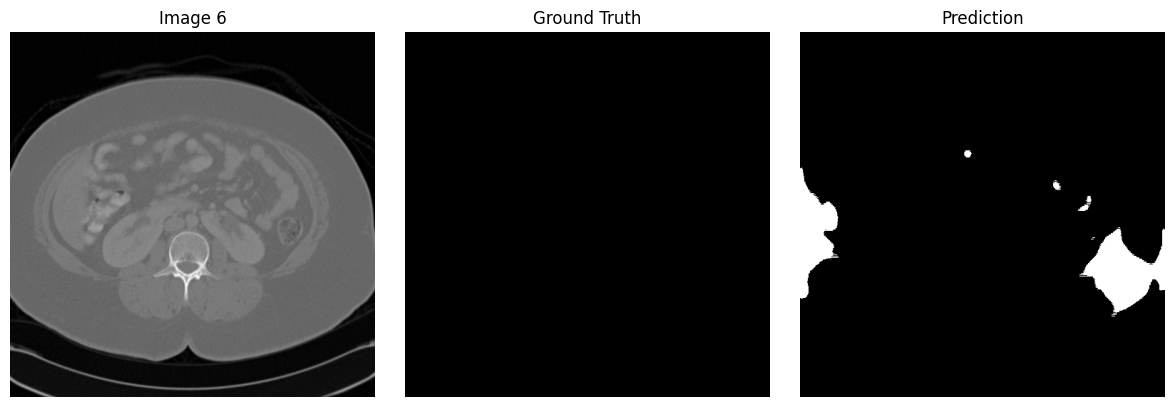

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import importlib.util

# === Load UNet++ Architecture ===
unetpp_path = "/content/drive/MyDrive/unetpp_input_adapter_ct.py"
spec = importlib.util.spec_from_file_location("UNetPP", unetpp_path)
unetpp_module = importlib.util.module_from_spec(spec)
spec.loader.exec_module(unetpp_module)
UNetPlusPlus = unetpp_module.UNetPlusPlus

# === Build Model and Load Weights ===
input_shape = (512, 512, 1)
model_instance = UNetPlusPlus(input_shape=input_shape)
model = model_instance.BuildNetwork()

model_path = "/content/drive/MyDrive/input_adapter_layers/input_adapter_layers/shapeprior_input_adapter_freeze_firstlayer.h5"

# >>> IMPORTANT: load the trained weights <<<
# by_name/skip_mismatch protect you in case of slight naming/shape differences
model.load_weights(model_path, by_name=True, skip_mismatch=True)

# === Load and Preprocess Images and Masks ===
img_dir = "/content/drive/MyDrive/SQU_split_tumor_80_10_10/test/images"
mask_dir = "/content/drive/MyDrive/SQU_split_tumor_80_10_10/test/masks"
img_size = 512

image_ids = sorted([
    f for f in os.listdir(img_dir)
    if f.endswith(".png") and os.path.exists(os.path.join(mask_dir, f))
])

images, masks = [], []
for img_id in image_ids:
    img = cv2.imread(os.path.join(img_dir, img_id), cv2.IMREAD_GRAYSCALE).astype(np.float32) / 255.0
    msk = cv2.imread(os.path.join(mask_dir, img_id), cv2.IMREAD_GRAYSCALE).astype(np.float32)
    msk = (msk >= 255).astype(np.float32)

    img = cv2.resize(img, (img_size, img_size), interpolation=cv2.INTER_LINEAR)
    msk = cv2.resize(msk, (img_size, img_size), interpolation=cv2.INTER_NEAREST)

    images.append(img[..., None])
    masks.append(msk[..., None])

images = np.array(images, dtype=np.float32)  # (N,512,512,1)
masks  = np.array(masks,  dtype=np.float32)  # (N,512,512,1)

# === Predict ===
preds = model.predict(images, batch_size=2, verbose=1)  # (N,H,W,1) or (N,H,W)

# Ensure single-channel CHW
if preds.ndim == 3:
    preds = preds[..., None]
elif preds.shape[-1] > 1:
    print(f"[warn] model output has {preds.shape[-1]} channels; using channel 0")
    preds = preds[..., :1]

# If last layer had no sigmoid, apply it now (safe even if already sigmoid)
preds_prob = tf.math.sigmoid(preds).numpy()

# Sanity checks
print("preds_prob shape:", preds_prob.shape)
print("preds_prob range: min =", float(preds_prob.min()), "max =", float(preds_prob.max()))

# Binarize
preds_bin = (preds_prob > 0.5).astype(np.float32)

# === Metrics (global micro) ===
def dice_score(y_true, y_pred, smooth=1e-6):
    inter = np.sum(y_true * y_pred)
    return (2.0 * inter) / (np.sum(y_true) + np.sum(y_pred) + smooth)

def iou_score(y_true, y_pred, smooth=1e-6):
    inter = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred) - inter
    return (inter + smooth) / (union + smooth)

overall_dice = dice_score(masks, preds_bin)
overall_iou  = iou_score(masks, preds_bin)

print(f"Overall Dice Score: {overall_dice:.4f}")
print(f"Overall IoU Score : {overall_iou:.4f}")

# === Visualize a few ===
for i in range(min(6, len(images))):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(images[i].squeeze(), cmap='gray')
    plt.title(f"Image {i+1}"); plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(masks[i].squeeze(), cmap='gray', vmin=0, vmax=1)
    plt.title("Ground Truth"); plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(preds_bin[i].squeeze(), cmap='gray', vmin=0, vmax=1)
    plt.title("Prediction"); plt.axis('off')

    plt.tight_layout(); plt.show()


70/70 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step
preds_prob shape: (139, 512, 512, 1)
preds_prob range: min = 0.5 max = 0.7310585379600525
Overall Dice Score: 0.0173
Overall IoU Score : 0.0087


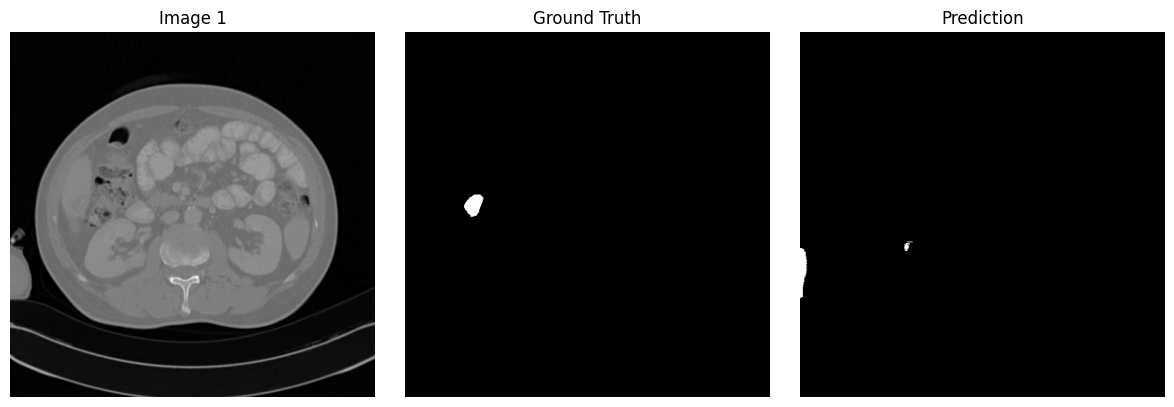

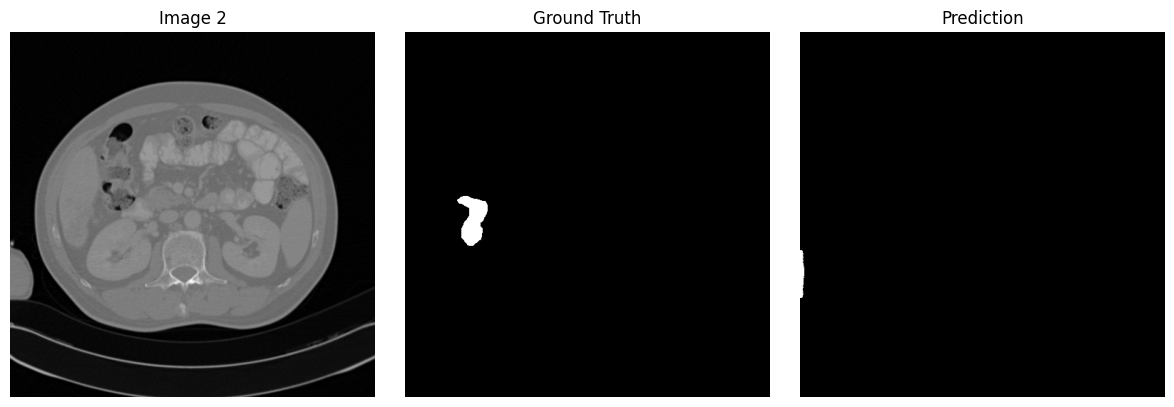

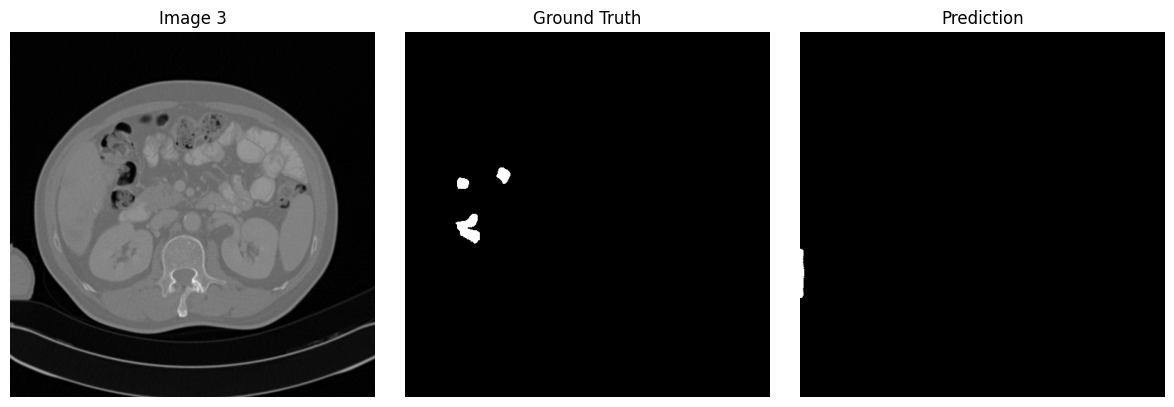

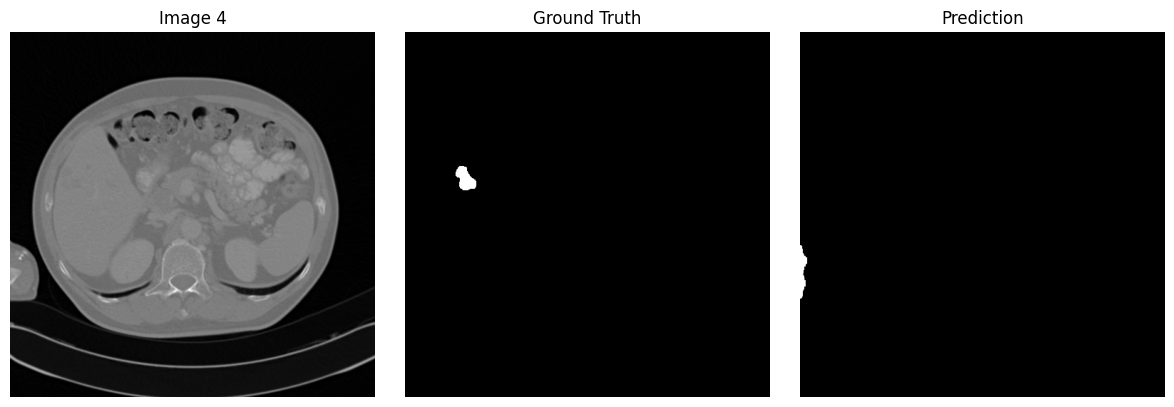

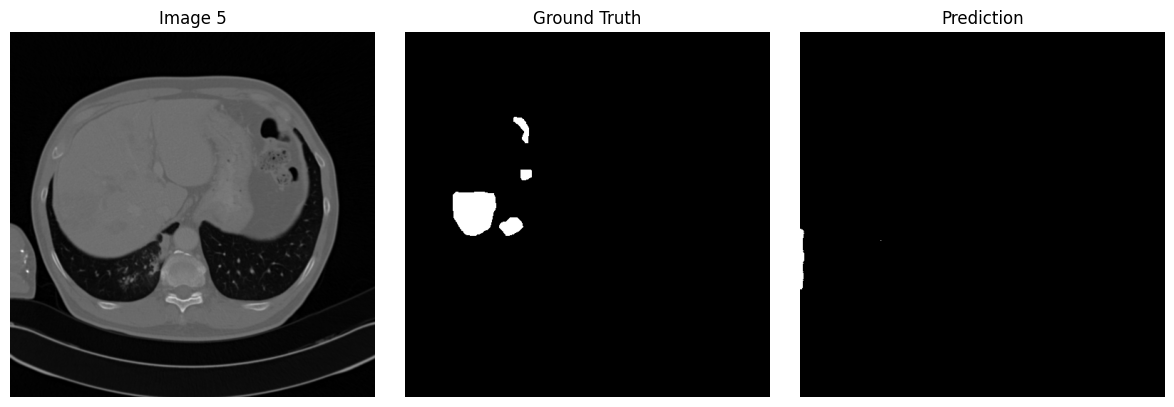

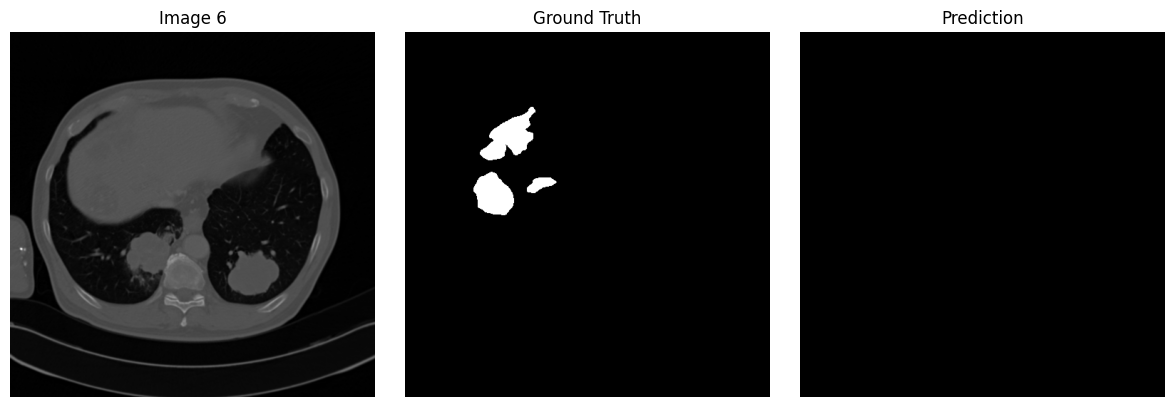

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import importlib.util

# === Load UNet++ Architecture ===
unetpp_path = "/content/drive/MyDrive/unetpp_input_adapter_ct.py"
spec = importlib.util.spec_from_file_location("UNetPP", unetpp_path)
unetpp_module = importlib.util.module_from_spec(spec)
spec.loader.exec_module(unetpp_module)
UNetPlusPlus = unetpp_module.UNetPlusPlus

# === Build Model and Load Weights ===
input_shape = (512, 512, 1)
model_instance = UNetPlusPlus(input_shape=input_shape)
model = model_instance.BuildNetwork()

model_path = "/content/drive/MyDrive/input_adapter_layers/input_adapter_layers/shapeprior_input_adapter_freeze_firstlayer.h5"

# >>> IMPORTANT: load the trained weights <<<
# by_name/skip_mismatch protect you in case of slight naming/shape differences
model.load_weights(model_path, by_name=True, skip_mismatch=True)

# === Load and Preprocess Images and Masks ===
img_dir = "/content/drive/MyDrive/SQU_split_tumor_80_10_10/val/images"
mask_dir = "/content/drive/MyDrive/SQU_split_tumor_80_10_10/val/masks"
img_size = 512

image_ids = sorted([
    f for f in os.listdir(img_dir)
    if f.endswith(".png") and os.path.exists(os.path.join(mask_dir, f))
])

images, masks = [], []
for img_id in image_ids:
    img = cv2.imread(os.path.join(img_dir, img_id), cv2.IMREAD_GRAYSCALE).astype(np.float32) / 255.0
    msk = cv2.imread(os.path.join(mask_dir, img_id), cv2.IMREAD_GRAYSCALE).astype(np.float32)
    msk = (msk >= 255).astype(np.float32)

    img = cv2.resize(img, (img_size, img_size), interpolation=cv2.INTER_LINEAR)
    msk = cv2.resize(msk, (img_size, img_size), interpolation=cv2.INTER_NEAREST)

    images.append(img[..., None])
    masks.append(msk[..., None])

images = np.array(images, dtype=np.float32)  # (N,512,512,1)
masks  = np.array(masks,  dtype=np.float32)  # (N,512,512,1)

# === Predict ===
preds = model.predict(images, batch_size=2, verbose=1)  # (N,H,W,1) or (N,H,W)

# Ensure single-channel CHW
if preds.ndim == 3:
    preds = preds[..., None]
elif preds.shape[-1] > 1:
    print(f"[warn] model output has {preds.shape[-1]} channels; using channel 0")
    preds = preds[..., :1]

# If last layer had no sigmoid, apply it now (safe even if already sigmoid)
preds_prob = tf.math.sigmoid(preds).numpy()

# Sanity checks
print("preds_prob shape:", preds_prob.shape)
print("preds_prob range: min =", float(preds_prob.min()), "max =", float(preds_prob.max()))

# Binarize
preds_bin = (preds_prob > 0.5).astype(np.float32)

# === Metrics (global micro) ===
def dice_score(y_true, y_pred, smooth=1e-6):
    inter = np.sum(y_true * y_pred)
    return (2.0 * inter) / (np.sum(y_true) + np.sum(y_pred) + smooth)

def iou_score(y_true, y_pred, smooth=1e-6):
    inter = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred) - inter
    return (inter + smooth) / (union + smooth)

overall_dice = dice_score(masks, preds_bin)
overall_iou  = iou_score(masks, preds_bin)

print(f"Overall Dice Score: {overall_dice:.4f}")
print(f"Overall IoU Score : {overall_iou:.4f}")

# === Visualize a few ===
for i in range(min(6, len(images))):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(images[i].squeeze(), cmap='gray')
    plt.title(f"Image {i+1}"); plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(masks[i].squeeze(), cmap='gray', vmin=0, vmax=1)
    plt.title("Ground Truth"); plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(preds_bin[i].squeeze(), cmap='gray', vmin=0, vmax=1)
    plt.title("Prediction"); plt.axis('off')

    plt.tight_layout(); plt.show()


In [ ]:
# === ADEST-U-Net — Test-set evaluation + subsample bootstrap (K=15, iters=1000) ===
import os, cv2, gc, numpy as np, tensorflow as tf, importlib.util
from tensorflow.keras.models import load_model
from tensorflow.keras import layers

# ------------------- EDIT THESE IF NEEDED -------------------
MODEL_PATH = "/content/drive/MyDrive/track3/dual_encoder_sharedtail_adapted_trained_dropout0.3_lrSched (1).h5"
ARCH_PATH  = "/content/drive/MyDrive/track3/dual_encoder_with_shared_tail_adapted (1).py"  # used only if direct load fails
IMG_DIR    = "/content/drive/MyDrive/final_split_balanced/final_split_balanced/test/images"
MASK_DIR   = "/content/drive/MyDrive/final_split_balanced/final_split_balanced/test/masks"
# ------------------------------------------------------------

IMG_SIZE = 512
THRESH   = 0.5
BATCH    = 4

# Optional: GPU memory growth
for g in tf.config.list_physical_devices("GPU"):
    try: tf.config.experimental.set_memory_growth(g, True)
    except: pass

# ---- Build arch if needed (weights-only .h5) ----
def build_arch_from_file(arch_path, input_shape=(IMG_SIZE, IMG_SIZE, 1)):
    spec = importlib.util.spec_from_file_location("dual_mod", arch_path)
    dual_mod = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(dual_mod)
    return dual_mod.build_dual_encoder_with_shared_tail_adapted(
        input_shape=input_shape, filters=[32,64,128,256,512], dropout_rate=0.3
    )

def load_model_safely(model_path, arch_path):
    try:
        m = load_model(model_path, compile=False)
        return m
    except Exception:
        m = build_arch_from_file(arch_path)
        m.load_weights(model_path, by_name=True, skip_mismatch=True)
        return m

# ---- Baseline-identical preprocessing ----
def load_image_gray_512(path_img, out_size=IMG_SIZE):
    img = cv2.imread(path_img, cv2.IMREAD_GRAYSCALE).astype(np.float32) / 255.0
    img = cv2.resize(img, (out_size, out_size), interpolation=cv2.INTER_LINEAR)
    return np.expand_dims(img, axis=-1)

def load_mask_bin_512(path_mask, out_size=IMG_SIZE):
    m = cv2.imread(path_mask, cv2.IMREAD_GRAYSCALE).astype(np.float32)
    m = cv2.resize(m, (out_size, out_size), interpolation=cv2.INTER_NEAREST)
    m = (m >= 255).astype(np.float32)  # exact baseline binarization
    return np.expand_dims(m, axis=-1)

# ---- Collect filenames ----
image_ids = sorted([
    f for f in os.listdir(IMG_DIR)
    if f.lower().endswith(".png") and os.path.exists(os.path.join(MASK_DIR, f))
])
print(f"Found {len(image_ids)} image/mask pairs.")

# ---- Load images & masks ----
images, masks = [], []
for fname in image_ids:
    images.append(load_image_gray_512(os.path.join(IMG_DIR, fname), IMG_SIZE))
    masks.append (load_mask_bin_512 (os.path.join(MASK_DIR, fname), IMG_SIZE))

images = np.array(images, dtype=np.float32)   # (N,512,512,1)
masks  = np.array(masks,  dtype=np.float32)   # (N,512,512,1)

# ---- Load model & predict ----
model = load_model_safely(MODEL_PATH, ARCH_PATH)
# If your model outputs 256x256, upsample to 512 with a resizing layer:
out = model.output
if out.shape.rank == 4 and (out.shape[1] != IMG_SIZE or out.shape[2] != IMG_SIZE):
    out = layers.Resizing(IMG_SIZE, IMG_SIZE, interpolation="nearest", name="resize_to_512")(out)
    from tensorflow.keras.models import Model
    model = Model(inputs=model.input, outputs=out)

preds = model.predict(images, batch_size=BATCH, verbose=1)  # (N,H,W,1) or (N,H,W)
if preds.ndim == 4:
    preds = preds[..., 0]
preds_bin = (preds > THRESH).astype(np.float32)[..., np.newaxis]  # (N,512,512,1)

# ---- Global (micro) Dice/IoU ----
def dice_micro(y_true, y_pred, eps=1e-6):
    inter = np.sum(y_true * y_pred, dtype=np.float64)
    return (2.0 * inter) / (np.sum(y_true, dtype=np.float64) + np.sum(y_pred, dtype=np.float64) + eps)

def iou_micro(y_true, y_pred, eps=1e-6):
    inter = np.sum(y_true * y_pred, dtype=np.float64)
    union = np.sum(y_true, dtype=np.float64) + np.sum(y_pred, dtype=np.float64) - inter
    return (inter + eps) / (union + eps)

overall_dice = dice_micro(masks, preds_bin)
overall_iou  = iou_micro(masks, preds_bin)
print(f"\nOverall Dice (micro): {overall_dice:.4f}")
print(f"Overall IoU  (micro): {overall_iou:.4f}")

# =========================
# Subsample Bootstrap on Mean Dice (slice-level)
#   sample_size = 15, n_iters = 1000
# =========================
import numpy as np

def dice_per_slice(y_true, y_pred, eps=1e-6):
    y_true = y_true.astype(np.float32).reshape(len(y_true), -1)
    y_pred = y_pred.astype(np.float32).reshape(len(y_pred), -1)
    inter  = (y_true * y_pred).sum(axis=1)
    denom  = y_true.sum(axis=1) + y_pred.sum(axis=1) + eps
    return (2.0 * inter) / denom  # (N,)

def subsample_bootstrap_mean(values, sample_size, n_iters=1000, seed=123):
    rng = np.random.default_rng(seed)
    values = np.asarray(values, dtype=np.float32)
    N = len(values)
    if N == 0:
        raise ValueError("Empty values for bootstrap.")
    boot_means = np.empty(n_iters, dtype=np.float32)
    for k in range(n_iters):
        idx = rng.integers(0, N, size=sample_size)  # draw K with replacement
        boot_means[k] = values[idx].mean()
    ci_low, ci_high = np.percentile(boot_means, [2.5, 97.5])
    return float(values.mean()), float(values.std(ddof=1)), float(ci_low), float(ci_high), boot_means

# Compute per-slice Dice and bootstrap
slice_dice = dice_per_slice(masks, preds_bin)
SAMPLE_SIZE = 15
N_ITERS     = 1000

mean_d, sd_d, ci_lo, ci_hi, boot_means = subsample_bootstrap_mean(
    slice_dice, sample_size=SAMPLE_SIZE, n_iters=N_ITERS, seed=123
)

print("\n[Subsample Bootstrap — ADEST-U-Net (slice-level)]")
print(f"Observed mean Dice (all slices) : {mean_d:.4f}")
print(f"Slice std. dev.                 : {sd_d:.4f}")
print(f"95% CI for mean (bootstrap, K=15, iters=1000): [{ci_lo:.4f}, {ci_hi:.4f}]")

gc.collect()


Found 57 image/mask pairs.


AttributeError: 'tuple' object has no attribute 'rank'

Found 57 image/mask pairs.
Loading ADEST-U-Net (proposed)...
Loading UNet++ baseline...
Predicting with ADEST-U-Net...
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step
Predicting with UNet++ baseline...
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 147ms/step

######## Subset Size = 15 (paired subset bootstrap, micro metrics) ########

DICE distributions (subset micro-means & paired difference):
Proposed Dice subset-micro: mean=0.7106, 95% CI=[0.5414, 0.8384]
Baseline Dice subset-micro: mean=0.6929, 95% CI=[0.5750, 0.7694]
Improvement (Proposed - Baseline) Dice: mean=0.0177, 95% CI=[-0.1252, 0.1451]
Two-sided p-value (Dice): 0.7940

IoU distributions (subset micro-means & paired difference):
Proposed IoU subset-micro: mean=0.5564, 95% CI=[0.3711, 0.7217]
Baseline IoU subset-micro: mean=0.5322, 95% CI=[0.4035, 0.6252]
Improvement (Proposed - Baseline) IoU: mean=0.0242, 95% CI=[-0.1387, 0.1835]
Two-sided p-value (IoU): 0.7940


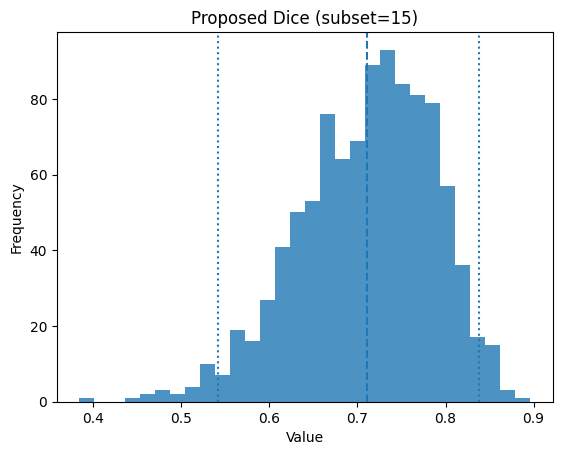

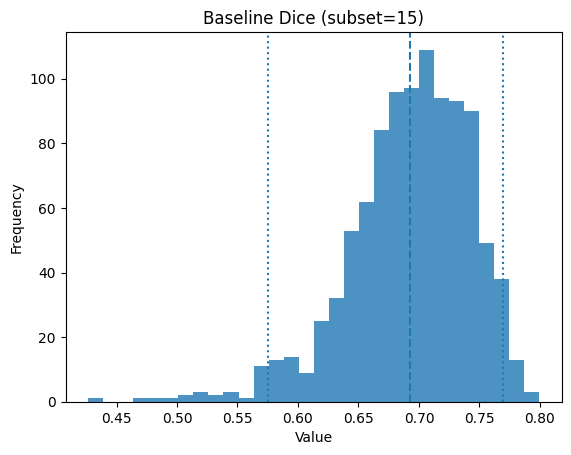

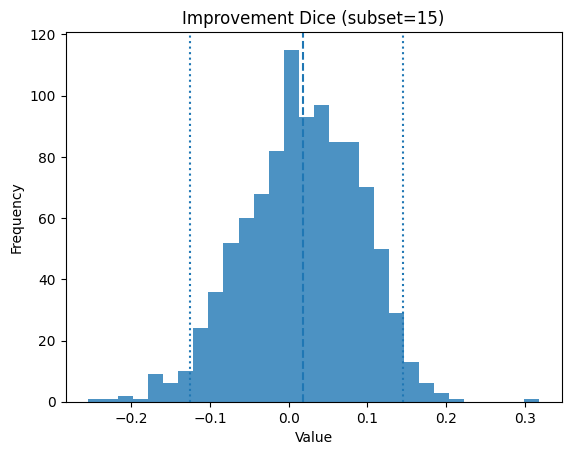

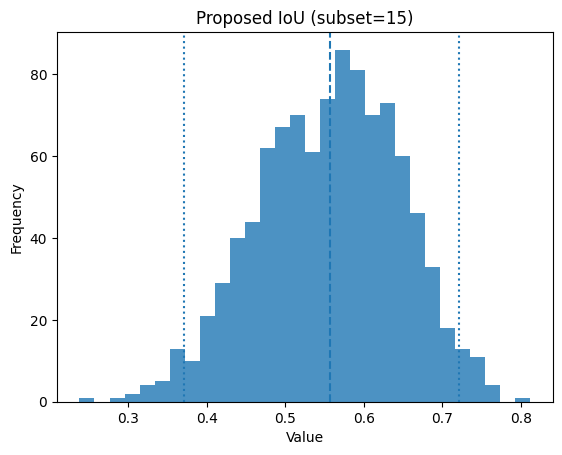

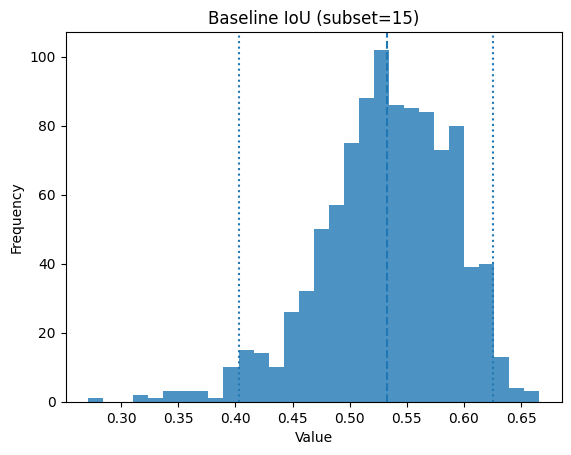

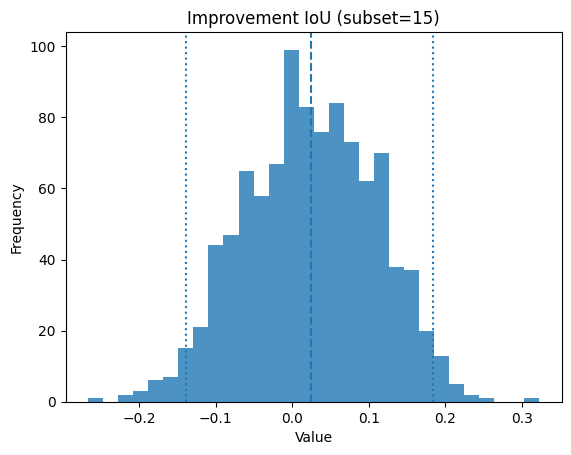

63136

In [ ]:
# ============================================
# Paired Subset Bootstrap WITHOUT per-image arrays
# (Micro Dice/IoU computed per sampled subset)
# ============================================

import os, gc, cv2, importlib.util
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

# ------------------- USER PATHS -------------------
# Proposed (ADEST-U-Net)
MODEL_PATH_NEW = "/content/drive/MyDrive/track3/dual_encoder_sharedtail_adapted_trained_dropout0.3_lrSched (1).h5"
ARCH_PATH_NEW  = "/content/drive/MyDrive/track3/dual_encoder_with_shared_tail_adapted (1).py"  # used only if direct load fails

# Baseline (UNet++)
UNETPP_PATH  = "/content/drive/MyDrive/workspace/orkspace/UNet-Plus-Plus---Brain-Tumor-Segmentation/UNetPP.py"
BASELINE_WTS = "/content/drive/MyDrive/shape_prior_models/shape_prior_models/shapeprior_no_weigts_start_from_scratch.h5"

# Data
IMG_DIR = "/content/drive/MyDrive/final_split_balanced/final_split_balanced/test/images"
MSK_DIR = "/content/drive/MyDrive/final_split_balanced/final_split_balanced/test/masks"

# ------------------- SETTINGS -------------------
IMG_SIZE      = 512
THRESH        = 0.5
BATCH_SIZE    = 2

# Bootstrap
N_BOOT        = 1000         # number of iterations
SUBSET_SIZE   = 15           # number of images per iteration (with replacement)
RNG_SEED      = 42
PLOT_HISTS    = True         # set False to skip plots

# -------------------------------------------------

# Optional: GPU memory growth
for g in tf.config.list_physical_devices("GPU"):
    try: tf.config.experimental.set_memory_growth(g, True)
    except: pass

# ------------------- Utilities -------------------
def build_adest_from_file(arch_path, input_shape=(IMG_SIZE, IMG_SIZE, 1)):
    spec = importlib.util.spec_from_file_location("dual_mod", arch_path)
    dual_mod = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(dual_mod)
    return dual_mod.build_dual_encoder_with_shared_tail_adapted(
        input_shape=input_shape, filters=[32,64,128,256,512], dropout_rate=0.3
    )

def load_new_model_safely(model_path, arch_path):
    """Try direct load; if it fails (weights-only), rebuild and load by name."""
    try:
        m = load_model(model_path, compile=False)
        return m
    except Exception:
        m = build_adest_from_file(arch_path)
        m.load_weights(model_path, by_name=True, skip_mismatch=True)
        return m

def load_unetpp_model(unetpp_path, weights_path, input_shape=(512,512,1)):
    spec = importlib.util.spec_from_file_location("UNetPP", unetpp_path)
    unetpp_module = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(unetpp_module)
    UNetPlusPlus = unetpp_module.UNetPlusPlus
    model_instance = UNetPlusPlus(input_shape=input_shape)
    model = model_instance.BuildNetwork()
    model.load_weights(weights_path)
    return model

def load_data(img_dir, msk_dir, img_size=512):
    image_ids = sorted([f for f in os.listdir(img_dir)
                        if f.lower().endswith(".png") and os.path.exists(os.path.join(msk_dir, f))])
    images, masks = [], []
    for img_id in image_ids:
        img = cv2.imread(os.path.join(img_dir, img_id), cv2.IMREAD_GRAYSCALE).astype(np.float32) / 255.0
        msk = cv2.imread(os.path.join(msk_dir, img_id), cv2.IMREAD_GRAYSCALE).astype(np.float32)

        # exact baseline binarization
        msk = (msk >= 255).astype(np.float32)

        img = cv2.resize(img, (img_size, img_size), interpolation=cv2.INTER_LINEAR)
        msk = cv2.resize(msk, (img_size, img_size), interpolation=cv2.INTER_NEAREST)

        images.append(np.expand_dims(img, axis=-1))
        masks.append(np.expand_dims(msk, axis=-1))

    images = np.array(images, dtype=np.float32)    # (N, H, W, 1)
    masks  = np.array(masks,  dtype=np.float32)    # (N, H, W, 1)
    return image_ids, images, masks

def ensure_pred_shape(preds, img_size=512):
    """Ensure (N,H,W) float array; threshold later."""
    if preds.ndim == 4:
        preds = preds[..., 0]  # (N,H,W,1)->(N,H,W)
    elif preds.ndim != 3:
        raise ValueError(f"Unexpected preds shape: {preds.shape}")
    if preds.shape[1] != img_size or preds.shape[2] != img_size:
        preds = np.stack([cv2.resize(p, (img_size, img_size), interpolation=cv2.INTER_NEAREST) for p in preds], axis=0)
    return preds

# --- Micro metrics on a subset (aggregate pixels across chosen indices) ---
def micro_dice_for_indices(Y, P, idx, smooth=1e-6):
    """
    Y: (N,H,W,1) ground truth (0/1)
    P: (N,H,W,1) predicted (0/1)
    idx: 1D array of selected indices (with replacement)
    Computes Dice by summing over pixels across the sampled subset.
    """
    # Sum over batch dimension only for selected items
    # Cast to float64 for numerical stability on large sums
    inter = np.sum(Y[idx] * P[idx], dtype=np.float64)
    total = np.sum(Y[idx], dtype=np.float64) + np.sum(P[idx], dtype=np.float64)
    return (2.0 * inter) / (total + smooth)

def micro_iou_for_indices(Y, P, idx, smooth=1e-6):
    inter = np.sum(Y[idx] * P[idx], dtype=np.float64)
    union = np.sum(Y[idx], dtype=np.float64) + np.sum(P[idx], dtype=np.float64) - inter
    return (inter + smooth) / (union + smooth)

# --- Paired subset bootstrap (using micro metrics; no per-image arrays) ---
def paired_subset_bootstrap(Y, P_new, P_base, subset_size=15, n_boot=1000, seed=42):
    """
    Returns:
      dice_new_means, dice_base_means, dice_diff
      iou_new_means,  iou_base_means,  iou_diff
    Each array has length n_boot (one value per bootstrap iteration).
    """
    rng = np.random.default_rng(seed)
    N = Y.shape[0]
    dice_new_means  = np.empty(n_boot, dtype=np.float64)
    dice_base_means = np.empty(n_boot, dtype=np.float64)
    dice_diff       = np.empty(n_boot, dtype=np.float64)
    iou_new_means   = np.empty(n_boot, dtype=np.float64)
    iou_base_means  = np.empty(n_boot, dtype=np.float64)
    iou_diff        = np.empty(n_boot, dtype=np.float64)

    for b in range(n_boot):
        idx = rng.integers(0, N, size=subset_size)  # sample image indices with replacement
        # micro subset metrics
        d_new  = micro_dice_for_indices(Y, P_new,  idx)
        d_base = micro_dice_for_indices(Y, P_base, idx)
        i_new  = micro_iou_for_indices(Y, P_new,   idx)
        i_base = micro_iou_for_indices(Y, P_base,  idx)

        dice_new_means[b]  = d_new
        dice_base_means[b] = d_base
        dice_diff[b]       = d_new - d_base

        iou_new_means[b]   = i_new
        iou_base_means[b]  = i_base
        iou_diff[b]        = i_new - i_base

    return dice_new_means, dice_base_means, dice_diff, iou_new_means, iou_base_means, iou_diff

def summarize_dist(name, arr):
    lo, hi = np.percentile(arr, [2.5, 97.5])
    mean = arr.mean()
    print(f"{name}: mean={mean:.4f}, 95% CI=[{lo:.4f}, {hi:.4f}]")
    return mean, lo, hi

def plot_hist(samples, title, mean, lo, hi):
    plt.figure()
    plt.hist(samples, bins=30, alpha=0.8)
    plt.axvline(mean, linestyle='--')
    plt.axvline(lo, linestyle=':')
    plt.axvline(hi, linestyle=':')
    plt.title(title)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.show()

# ------------------- Pipeline -------------------
# 1) Load data
ids, X, Y = load_data(IMG_DIR, MSK_DIR, IMG_SIZE)
print(f"Found {len(ids)} image/mask pairs.")

# 2) Load models
print("Loading ADEST-U-Net (proposed)...")
model_new = load_new_model_safely(MODEL_PATH_NEW, ARCH_PATH_NEW)

print("Loading UNet++ baseline...")
model_base = load_unetpp_model(UNETPP_PATH, BASELINE_WTS, input_shape=(IMG_SIZE, IMG_SIZE, 1))

# 3) Predict (float probs), ensure shape (N,H,W), then binarize
print("Predicting with ADEST-U-Net...")
preds_new = model_new.predict(X, batch_size=BATCH_SIZE, verbose=1)
preds_new = ensure_pred_shape(preds_new, IMG_SIZE)
preds_new_bin = (preds_new > THRESH).astype(np.float32)[..., np.newaxis]  # (N,H,W,1)

print("Predicting with UNet++ baseline...")
preds_base = model_base.predict(X, batch_size=BATCH_SIZE, verbose=1)
preds_base = ensure_pred_shape(preds_base, IMG_SIZE)
preds_base_bin = (preds_base > THRESH).astype(np.float32)[..., np.newaxis]

# 4) Paired subset bootstrap (no per-image arrays anywhere)
(dice_new_boot, dice_base_boot, dice_diff_boot,
 iou_new_boot,  iou_base_boot,  iou_diff_boot) = paired_subset_bootstrap(
    Y, preds_new_bin, preds_base_bin,
    subset_size=SUBSET_SIZE, n_boot=N_BOOT, seed=RNG_SEED
)

# 5) Summaries + p-values
print(f"\n######## Subset Size = {SUBSET_SIZE} (paired subset bootstrap, micro metrics) ########")

print("\nDICE distributions (subset micro-means & paired difference):")
m1, l1, h1 = summarize_dist("Proposed Dice subset-micro",  dice_new_boot)
m2, l2, h2 = summarize_dist("Baseline Dice subset-micro",  dice_base_boot)
md, ld, hd = summarize_dist("Improvement (Proposed - Baseline) Dice", dice_diff_boot)
p_left  = (dice_diff_boot <= 0.0).mean()
p_right = (dice_diff_boot >= 0.0).mean()
p_two   = float(np.clip(2.0 * min(p_left, p_right), 0.0, 1.0))
print(f"Two-sided p-value (Dice): {p_two:.4f}")

print("\nIoU distributions (subset micro-means & paired difference):")
m1i, l1i, h1i = summarize_dist("Proposed IoU subset-micro",  iou_new_boot)
m2i, l2i, h2i = summarize_dist("Baseline IoU subset-micro",  iou_base_boot)
mdi, ldi, hdi = summarize_dist("Improvement (Proposed - Baseline) IoU", iou_diff_boot)
p_left_i  = (iou_diff_boot <= 0.0).mean()
p_right_i = (iou_diff_boot >= 0.0).mean()
p_two_i   = float(np.clip(2.0 * min(p_left_i, p_right_i), 0.0, 1.0))
print(f"Two-sided p-value (IoU): {p_two_i:.4f}")

# 6) Plots
if PLOT_HISTS:
    plot_hist(dice_new_boot,  f"Proposed Dice (subset={SUBSET_SIZE})", m1,  l1,  h1)
    plot_hist(dice_base_boot, f"Baseline Dice (subset={SUBSET_SIZE})", m2,  l2,  h2)
    plot_hist(dice_diff_boot, f"Improvement Dice (subset={SUBSET_SIZE})", md,  ld,  hd)

    plot_hist(iou_new_boot,   f"Proposed IoU (subset={SUBSET_SIZE})",  m1i, l1i, h1i)
    plot_hist(iou_base_boot,  f"Baseline IoU (subset={SUBSET_SIZE})",  m2i, l2i, h2i)
    plot_hist(iou_diff_boot,  f"Improvement IoU (subset={SUBSET_SIZE})", mdi, ldi, hdi)

gc.collect()


In [ ]:
# ============================================
# Paired Bootstrap: ADEST-U-Net vs Baseline UNet++
# - Computes per-image Dice/IoU
# - Paired bootstrap on random smaller subsets
# ============================================

import os, cv2, gc, numpy as np, tensorflow as tf, importlib.util, random

# ------------------- EDIT THESE -------------------
# Proposed (ADEST-U-Net)
PROPOSED_MODEL_PATH = "/content/drive/MyDrive/track3/dual_encoder_sharedtail_adapted_trained_dropout0.3_lrSched (1).h5"
PROPOSED_ARCH_PATH  = "/content/drive/MyDrive/track3/dual_encoder_with_shared_tail_adapted (1).py"

# Baseline UNet++
UNETPP_ARCH_PATH    = "/content/drive/MyDrive/workspace/orkspace/UNet-Plus-Plus---Brain-Tumor-Segmentation/UNetPP.py"
UNETPP_WEIGHTS_PATH = "/content/drive/MyDrive/shape_prior_models/shape_prior_models/shapeprior_no_weigts_start_from_scratch.h5"

# Test data (57 pairs expected)
IMG_DIR             = "/content/drive/MyDrive/final_split_balanced/final_split_balanced/test/images"
MASK_DIR            = "/content/drive/MyDrive/final_split_balanced/final_split_balanced/test/masks"
# --------------------------------------------------

IMG_SIZE   = 512
THRESH     = 0.5
BATCH      = 2

# Bootstrap params
B               = 5000   # iterations (1000–10000 reasonable)
SUBSET_SIZE     = 10    # "smaller subsets" per your request (<= n). Set to len(dataset) for classic bootstrap
RANDOM_SEED     = 42     # for reproducibility

# Optional: make GPU memory allocation dynamic
for g in tf.config.list_physical_devices("GPU"):
    try:
        tf.config.experimental.set_memory_growth(g, True)
    except Exception:
        pass

np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

# ----------------- Utility: Metrics -----------------
def dice_score_all(y_true, y_pred, smooth=1e-6):
    """Global (micro) Dice over the whole set."""
    inter = np.sum(y_true * y_pred)
    return (2.0 * inter) / (np.sum(y_true) + np.sum(y_pred) + smooth)

def iou_score_all(y_true, y_pred, smooth=1e-6):
    """Global (micro) IoU over the whole set."""
    inter = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred) - inter
    return (inter + smooth) / (union + smooth)

def per_image_dice(y_true, y_pred, smooth=1e-6):
    dices = []
    for i in range(len(y_true)):
        inter = np.sum(y_true[i] * y_pred[i])
        d = (2.0 * inter) / (np.sum(y_true[i]) + np.sum(y_pred[i]) + smooth)
        dices.append(d)
    return np.array(dices, dtype=np.float32)

def per_image_iou(y_true, y_pred, smooth=1e-6):
    ious = []
    for i in range(len(y_true)):
        inter = np.sum(y_true[i] * y_pred[i])
        union = np.sum(y_true[i]) + np.sum(y_pred[i]) - inter
        i = (inter + smooth) / (union + smooth)
        ious.append(i)
    return np.array(ious, dtype=np.float32)

# --------------- Load Data (once) -------------------
image_ids = sorted([f for f in os.listdir(IMG_DIR)
                    if f.lower().endswith(".png") and os.path.exists(os.path.join(MASK_DIR, f))])
print(f"Found {len(image_ids)} image/mask pairs.")

images, masks = [], []
for img_id in image_ids:
    img = cv2.imread(os.path.join(IMG_DIR, img_id), cv2.IMREAD_GRAYSCALE).astype(np.float32) / 255.0
    msk = cv2.imread(os.path.join(MASK_DIR, img_id), cv2.IMREAD_GRAYSCALE).astype(np.float32)

    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_LINEAR)
    msk = cv2.resize(msk, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST)

    # Exact binarization as in your code
    msk = (msk >= 255).astype(np.float32)

    images.append(np.expand_dims(img, axis=-1))
    masks.append(np.expand_dims(msk, axis=-1))

images = np.array(images, dtype=np.float32)   # (N, 512, 512, 1)
masks  = np.array(masks,  dtype=np.float32)   # (N, 512, 512, 1)
N = len(images)
assert N == len(masks), "Images and masks count mismatch."

# --------------- Load Proposed (ADEST-U-Net) ----------
def build_proposed_from_file(arch_path, input_shape=(IMG_SIZE, IMG_SIZE, 1)):
    spec = importlib.util.spec_from_file_location("dual_mod", arch_path)
    dual_mod = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(dual_mod)
    # Build with your known defaults
    return dual_mod.build_dual_encoder_with_shared_tail_adapted(
        input_shape=input_shape, filters=[32,64,128,256,512], dropout_rate=0.3
    )

def load_proposed(model_path, arch_path):
    from tensorflow.keras.models import load_model
    try:
        m = load_model(model_path, compile=False)
        print("Loaded proposed model via load_model().")
        return m
    except Exception as e:
        print(f"Direct load failed ({e}). Building architecture and loading weights by name...")
        m = build_proposed_from_file(arch_path)
        m.load_weights(model_path, by_name=True, skip_mismatch=True)
        print("Loaded proposed weights by name into built architecture.")
        return m

proposed_model = load_proposed(PROPOSED_MODEL_PATH, PROPOSED_ARCH_PATH)

# --------------- Load Baseline UNet++ ----------------
# Expect an object UNetPlusPlus with .BuildNetwork()
spec = importlib.util.spec_from_file_location("UNetPP", UNETPP_ARCH_PATH)
unetpp_module = importlib.util.module_from_spec(spec)
spec.loader.exec_module(unetpp_module)
UNetPlusPlus = unetpp_module.UNetPlusPlus

uinst = UNetPlusPlus(input_shape=(IMG_SIZE, IMG_SIZE, 1))
baseline_model = uinst.BuildNetwork()
baseline_model.load_weights(UNETPP_WEIGHTS_PATH)
print("Loaded baseline UNet++ weights.")

# --------------- Predict (both models) ----------------
print("\nPredicting with ADEST-U-Net...")
proposed_preds = proposed_model.predict(images, batch_size=BATCH, verbose=1)
if proposed_preds.ndim == 4 and proposed_preds.shape[-1] == 1:
    proposed_preds = proposed_preds[..., 0]
elif proposed_preds.ndim != 3:
    raise ValueError(f"Unexpected proposed_preds shape: {proposed_preds.shape}")

print("Predicting with baseline UNet++...")
baseline_preds = baseline_model.predict(images, batch_size=BATCH, verbose=1)
if baseline_preds.ndim == 4 and baseline_preds.shape[-1] == 1:
    baseline_preds = baseline_preds[..., 0]
elif baseline_preds.ndim != 3:
    raise ValueError(f"Unexpected baseline_preds shape: {baseline_preds.shape}")

# Ensure size (N, 512, 512)
if proposed_preds.shape[1] != IMG_SIZE or proposed_preds.shape[2] != IMG_SIZE:
    proposed_preds = np.stack([cv2.resize(p, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST)
                               for p in proposed_preds], axis=0)
if baseline_preds.shape[1] != IMG_SIZE or baseline_preds.shape[2] != IMG_SIZE:
    baseline_preds = np.stack([cv2.resize(p, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST)
                               for p in baseline_preds], axis=0)

# Binarize
proposed_bin = (proposed_preds > THRESH).astype(np.float32)[..., np.newaxis]  # (N,H,W,1)
baseline_bin = (baseline_preds > THRESH).astype(np.float32)[..., np.newaxis]  # (N,H,W,1)

# --------------- Overall (micro) metrics ---------------
overall_dice_proposed = dice_score_all(masks, proposed_bin)
overall_iou_proposed  = iou_score_all(masks, proposed_bin)
overall_dice_baseline = dice_score_all(masks, baseline_bin)
overall_iou_baseline  = iou_score_all(masks, baseline_bin)

print("\n===== Global (Micro) Metrics =====")
print(f"Proposed (ADEST-U-Net): Dice={overall_dice_proposed:.4f}, IoU={overall_iou_proposed:.4f}")
print(f"Baseline (UNet++):      Dice={overall_dice_baseline:.4f}, IoU={overall_iou_baseline:.4f}")

# --------------- Per-image metrics --------------------
pdice_prop = per_image_dice(masks, proposed_bin)
pdice_base = per_image_dice(masks, baseline_bin)
piou_prop  = per_image_iou(masks, proposed_bin)
piou_base  = per_image_iou(masks, baseline_bin)

print("\nPer-image arrays ready. Running paired bootstrap ...")

# --------------- Paired Bootstrap ---------------------
if SUBSET_SIZE > N:
    raise ValueError(f"SUBSET_SIZE ({SUBSET_SIZE}) cannot exceed dataset size ({N}).")

def paired_bootstrap_diff(a_prop, a_base, B=5000, subset_size=30):
    """Returns diffs array for mean(a_prop[idx]) - mean(a_base[idx]) over bootstrapped subsets."""
    diffs = np.empty(B, dtype=np.float32)
    for b in range(B):
        idxs = np.random.choice(len(a_prop), size=subset_size, replace=True)
        diffs[b] = a_prop[idxs].mean() - a_base[idxs].mean()
    return diffs

# Dice diffs (proposed - baseline)
dice_diffs = paired_bootstrap_diff(pdice_prop, pdice_base, B=B, subset_size=SUBSET_SIZE)
dice_mean  = dice_diffs.mean()
dice_ci    = np.percentile(dice_diffs, [2.5, 97.5])
dice_p     = np.mean(dice_diffs <= 0.0)  # one-sided: probability baseline >= proposed

# IoU diffs (proposed - baseline)
iou_diffs = paired_bootstrap_diff(piou_prop, piou_base, B=B, subset_size=SUBSET_SIZE)
iou_mean  = iou_diffs.mean()
iou_ci    = np.percentile(iou_diffs, [2.5, 97.5])
iou_p     = np.mean(iou_diffs <= 0.0)

print("\n===== Paired Bootstrap (subset) =====")
print(f"[Dice]  Mean Δ (Prop-Base) = {dice_mean:.4f}, 95% CI = [{dice_ci[0]:.4f}, {dice_ci[1]:.4f}], p = {dice_p:.4f}")
print(f"[IoU ]  Mean Δ (Prop-Base) = {iou_mean:.4f},  95% CI = [{iou_ci[0]:.4f},  {iou_ci[1]:.4f}],  p = {iou_p:.4f}")

# Simple interpretation helper
def interpret(name, mean_delta, ci, p, alpha=0.05):
    better = "significantly better" if (ci[0] > 0 and p < alpha) else ("not significantly better" if p >= alpha else "inconclusive")
    return f"{name}: Proposed is {better} than baseline at α={alpha} (Δ={mean_delta:.4f}, CI={ci[0]:.4f}–{ci[1]:.4f}, p={p:.4f})."

print("\n===== Interpretation =====")
print(interpret("Dice", dice_mean, dice_ci, dice_p))
print(interpret("IoU ", iou_mean, iou_ci, iou_p))

gc.collect()


Found 57 image/mask pairs.
Direct load failed (Error when deserializing class 'Conv2DTranspose' using config={'name': 'up3', 'trainable': True, 'dtype': 'float32', 'filters': 256, 'kernel_size': [2, 2], 'strides': [2, 2], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None, 'output_padding': None}.

Exception encountered: Unrecognized keyword arguments passed to Conv2DTranspose: {'groups': 1}). Building architecture and loading weights by name...
Loaded proposed weights by name into built architecture.
Loaded baseline UNet++ w

71309

In [ ]:
# Sanity: not all-zero predictions?
import numpy as np
prop_pos_frac = (proposed_bin.sum() / proposed_bin.size)
base_pos_frac = (baseline_bin.sum() / baseline_bin.size)
print(f"Pos frac – proposed: {prop_pos_frac:.6f}, baseline: {base_pos_frac:.6f}")


Pos frac – proposed: 0.011404, baseline: 0.019429


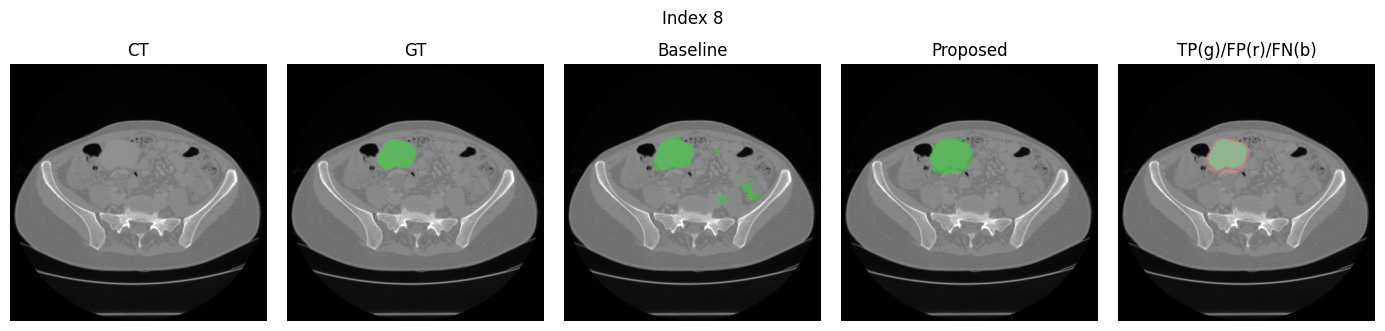

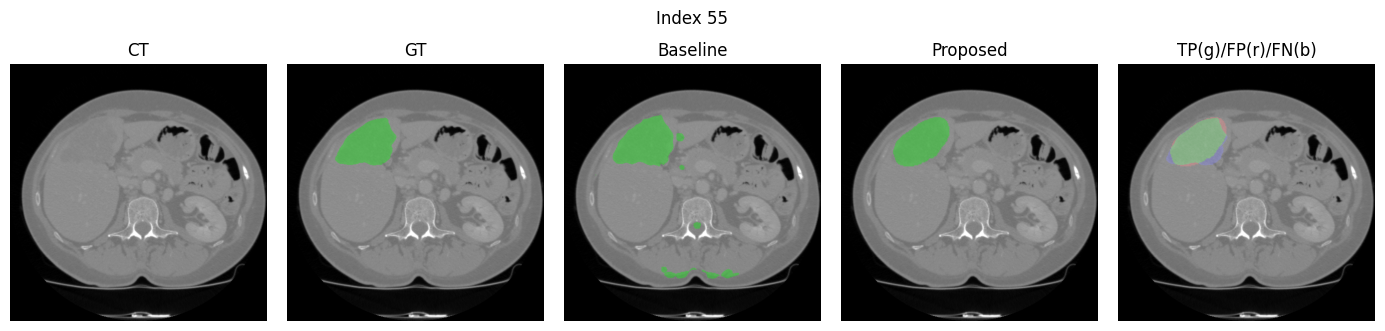

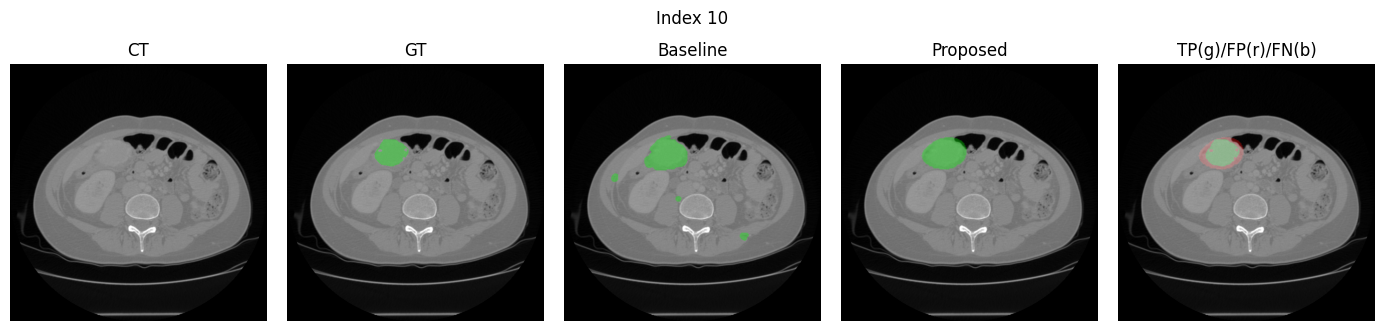

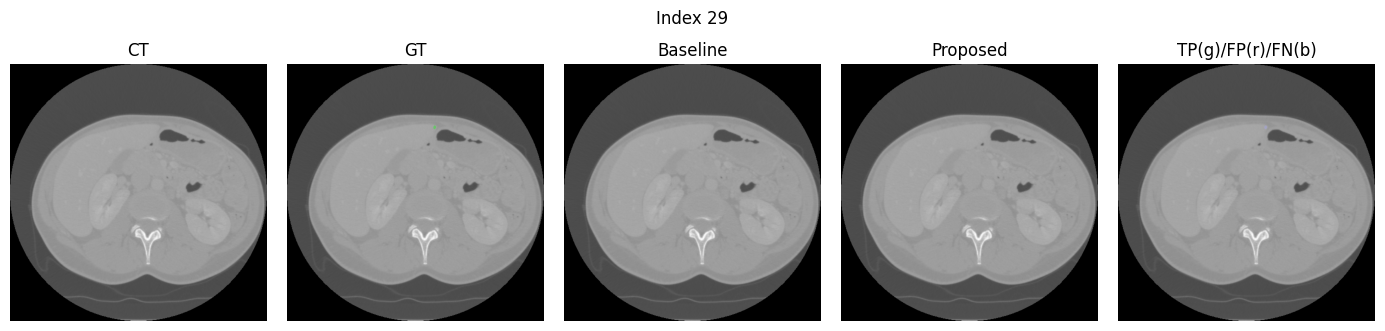

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def overlay_mask_on_ct(ct_01, mask_01, alpha=0.35):
    """
    ct_01: (H,W,1) or (H,W) float in [0,1]
    mask_01: (H,W) binary {0,1}
    returns RGB image with mask overlayed in green
    """
    if ct_01.ndim == 3 and ct_01.shape[-1] == 1:
        base = np.repeat(ct_01, 3, axis=-1)
    elif ct_01.ndim == 2:
        base = np.repeat(ct_01[..., None], 3, axis=-1)
    else:
        raise ValueError("ct_01 must be (H,W) or (H,W,1) in [0,1].")

    overlay = base.copy()
    green = np.zeros_like(base)
    green[..., 1] = 1.0  # pure green
    mask3 = np.repeat(mask_01[..., None], 3, axis=-1)
    overlay = np.where(mask3, (1 - alpha) * base + alpha * green, base)
    return np.clip(overlay, 0, 1)

def tp_fp_fn_composite(ct_01, gt_01, pred_01, alpha=0.35):
    """
    Colors: TP=green, FP=red, FN=blue over grayscale CT.
    """
    if ct_01.ndim == 3 and ct_01.shape[-1] == 1:
        base = np.repeat(ct_01, 3, axis=-1)
    elif ct_01.ndim == 2:
        base = np.repeat(ct_01[..., None], 3, axis=-1)
    else:
        raise ValueError("ct_01 must be (H,W) or (H,W,1).")

    gt = gt_01.astype(bool)
    pr = pred_01.astype(bool)

    tp = gt & pr
    fp = (~gt) & pr
    fn = gt & (~pr)

    comp = base.copy()
    # red channel for FP
    comp[..., 0] = np.where(fp, (1 - alpha) * comp[..., 0] + alpha * 1.0, comp[..., 0])
    # green channel for TP
    comp[..., 1] = np.where(tp, (1 - alpha) * comp[..., 1] + alpha * 1.0, comp[..., 1])
    # blue channel for FN
    comp[..., 2] = np.where(fn, (1 - alpha) * comp[..., 2] + alpha * 1.0, comp[..., 2])

    return np.clip(comp, 0, 1)

def show_examples(indices=(0, 10, 20, 30), show_tpfpfn=True, max_cols=5, figsize=(14, 3.2)):
    """
    indices: iterable of image indices to visualize
    show_tpfpfn: include TP/FP/FN composite column
    """
    cols = 4 + int(show_tpfpfn)  # CT, GT, Baseline, Proposed, [TP/FP/FN]
    for idx in indices:
        ct = images[idx].squeeze()          # (H,W) in [0,1]
        gt = masks[idx].squeeze()           # (H,W) {0,1}
        b  = baseline_bin[idx].squeeze()    # (H,W) {0,1}
        p  = proposed_bin[idx].squeeze()    # (H,W) {0,1}

        fig = plt.figure(figsize=figsize)
        ax = plt.subplot(1, cols, 1)
        ax.imshow(ct, cmap='gray', vmin=0, vmax=1); ax.set_title("CT"); ax.axis('off')

        ax = plt.subplot(1, cols, 2)
        ax.imshow(overlay_mask_on_ct(ct, gt)); ax.set_title("GT"); ax.axis('off')

        ax = plt.subplot(1, cols, 3)
        ax.imshow(overlay_mask_on_ct(ct, b)); ax.set_title("Baseline"); ax.axis('off')

        ax = plt.subplot(1, cols, 4)
        ax.imshow(overlay_mask_on_ct(ct, p)); ax.set_title("Proposed"); ax.axis('off')

        if show_tpfpfn:
            ax = plt.subplot(1, cols, 5)
            ax.imshow(tp_fp_fn_composite(ct, gt, p))
            ax.set_title("TP(g)/FP(r)/FN(b)")
            ax.axis('off')

        plt.suptitle(f"Index {idx}", y=1.02)
        plt.tight_layout()
        plt.show()

# Example usage:
show_examples(indices=[8, 55, 10, 29], show_tpfpfn=True)


In [ ]:
# ============================================
# ADEST-U-Net vs Baseline UNet++ — STRICT weights-only + Micro Bootstrap
# + Validation-optimized thresholds (per model)
# + Stratified pooled bootstrap by lesion size
# ============================================

import os, cv2, gc, numpy as np, tensorflow as tf, importlib.util, random, time
from tensorflow.keras.models import load_model

# --- Progress bar (tqdm) ---
try:
    from tqdm.auto import trange
    _tqdm = True
except Exception:
    _tqdm = False

# ------------------- PATHS (EDIT THESE) -------------------
# Test split
IMG_DIR_TEST  = "/content/drive/MyDrive/final_split_balanced/final_split_balanced/test/images"
MASK_DIR_TEST = "/content/drive/MyDrive/final_split_balanced/final_split_balanced/test/masks"
# Validation split (used to pick thresholds). Change to your real val path.
IMG_DIR_VAL   = "/content/drive/MyDrive/final_split_balanced/final_split_balanced/val/images"
MASK_DIR_VAL  = "/content/drive/MyDrive/final_split_balanced/final_split_balanced/val/masks"

# Proposed ADEST-U-Net (STRICT weights-only)
PROPOSED_ARCH_PATH    = "/content/drive/MyDrive/track3/dual_encoder_with_shared_tail_adapted (1).py"
PROPOSED_WEIGHTS_PATH = "/content/drive/MyDrive/track3/dual_encoder_sharedtail_adapted_trained_dropout0.3_lrSched (1).h5"  # <-- weights-only file

# Baseline UNet++
UNETPP_ARCH_PATH    = "/content/drive/MyDrive/workspace/orkspace/UNet-Plus-Plus---Brain-Tumor-Segmentation/UNetPP.py"
UNETPP_WEIGHTS_PATH = "/content/drive/MyDrive/shape_prior_models/shape_prior_models/shapeprior_no_weigts_start_from_scratch.h5"
# ----------------------------------------------------------

IMG_SIZE = 512
BATCH    = 2

# Bootstrap params
B            = 5000                # iterations
SUBSET_SIZE  = 30                  # for subset bootstrap; classic = set to N
RANDOM_SEED  = 42
ALPHA        = 0.10                # significance level
THR_GRID     = np.linspace(0.05, 0.95, 19)  # sweep for threshold optimization (Dice)

# GPU memory growth
for g in tf.config.list_physical_devices("GPU"):
    try: tf.config.experimental.set_memory_growth(g, True)
    except: pass

np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

# ----------------- I/O helpers -----------------
def load_split(img_dir, mask_dir, img_size=IMG_SIZE):
    if not (os.path.isdir(img_dir) and os.path.isdir(mask_dir)):
        return None, None, 0
    image_ids = sorted([f for f in os.listdir(img_dir)
                        if f.lower().endswith(".png") and os.path.exists(os.path.join(mask_dir, f))])
    if len(image_ids) == 0:
        return None, None, 0
    images, masks = [], []
    for img_id in image_ids:
        img = cv2.imread(os.path.join(img_dir, img_id), cv2.IMREAD_GRAYSCALE).astype(np.float32) / 255.0
        msk = cv2.imread(os.path.join(mask_dir, img_id), cv2.IMREAD_GRAYSCALE).astype(np.float32)
        img = cv2.resize(img, (img_size, img_size), interpolation=cv2.INTER_LINEAR)
        msk = cv2.resize(msk, (img_size, img_size), interpolation=cv2.INTER_NEAREST)
        msk = (msk >= 255).astype(np.float32)
        images.append(img[..., None])
        masks.append(msk[..., None])
    return np.array(images, np.float32), np.array(masks, np.float32), len(image_ids)

# ----------------- Proposed model (STRICT weights-only) -----------------
def build_proposed_from_file(arch_path, input_shape=(IMG_SIZE, IMG_SIZE, 1)):
    spec = importlib.util.spec_from_file_location("dual_mod", arch_path)
    dual_mod = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(dual_mod)
    return dual_mod.build_dual_encoder_with_shared_tail_adapted(
        input_shape=input_shape, filters=[32,64,128,256,512], dropout_rate=0.3
    )

def predict_proposed(images):
    model = build_proposed_from_file(PROPOSED_ARCH_PATH, input_shape=(IMG_SIZE, IMG_SIZE, 1))
    model.load_weights(PROPOSED_WEIGHTS_PATH)  # strict: no by_name, no skip_mismatch
    preds = model.predict(images, batch_size=BATCH, verbose=1)
    if preds.ndim == 4: preds = preds[..., 0]
    if preds.shape[1] != IMG_SIZE:
        preds = np.stack([cv2.resize(p, (IMG_SIZE, IMG_SIZE), cv2.INTER_NEAREST) for p in preds], axis=0)
    return preds  # float probs/logits in [0,1] typically

# ----------------- Baseline model -----------------
def build_baseline_from_file():
    spec = importlib.util.spec_from_file_location("UNetPP", UNETPP_ARCH_PATH)
    unetpp_module = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(unetpp_module)
    UNetPlusPlus = unetpp_module.UNetPlusPlus
    uinst = UNetPlusPlus(input_shape=(IMG_SIZE, IMG_SIZE, 1))
    model = uinst.BuildNetwork()
    model.load_weights(UNETPP_WEIGHTS_PATH)
    return model

def predict_baseline(images):
    model = build_baseline_from_file()
    preds = model.predict(images, batch_size=BATCH, verbose=1)
    if preds.ndim == 4: preds = preds[..., 0]
    return preds

# ----------------- Metrics -----------------
def dice_all(y_true, y_pred_bin, s=1e-6):
    inter = np.sum(y_true * y_pred_bin)
    return (2.0 * inter) / (np.sum(y_true) + np.sum(y_pred_bin) + s)

def iou_all(y_true, y_pred_bin, s=1e-6):
    inter = np.sum(y_true * y_pred_bin)
    union = np.sum(y_true) + np.sum(y_pred_bin) - inter
    return (inter + s) / (union + s)

# ====== 1) Load VALIDATION (for threshold selection) ======
Xv, Yv, Nv = load_split(IMG_DIR_VAL, MASK_DIR_VAL)
if Nv == 0:
    print("⚠️ Validation split not found or empty. Falling back to TEST for threshold tuning (not ideal).")
    Xv, Yv, Nv = load_split(IMG_DIR_TEST, MASK_DIR_TEST)
print(f"Validation pairs: {Nv}")

print("\nPredicting on VALIDATION...")
v_prop = predict_proposed(Xv)   # (Nv,H,W)
v_base = predict_baseline(Xv)   # (Nv,H,W)

# Flatten val for fast counts
yt_v = Yv.reshape(Nv, -1)
yp_prop_v = v_prop.reshape(Nv, -1)
yp_base_v = v_base.reshape(Nv, -1)

def best_threshold_micro(yt_flat, yp_flat, thr_grid=THR_GRID, metric="dice"):
    """
    Returns t*, best_score, (dice_at_t*, iou_at_t*).
    Micro (pooled) metric over the whole validation set.
    """
    best_t, best_score = None, -1.0
    best_pair = (None, None)
    for t in thr_grid:
        bin_ = (yp_flat >= t).astype(np.float32)
        tp = np.sum(yt_flat * bin_)
        p  = np.sum(yt_flat)
        pp = np.sum(bin_)
        dice = (2.0*tp) / (p + pp + 1e-6)
        iou  = (tp + 1e-6) / (p + pp - tp + 1e-6)
        score = dice if metric == "dice" else iou
        if score > best_score:
            best_score = score
            best_t = float(t)
            best_pair = (float(dice), float(iou))
    return best_t, float(best_score), best_pair

t_prop, score_prop, (dice_prop_v, iou_prop_v) = best_threshold_micro(yt_v, yp_prop_v, THR_GRID, metric="dice")
t_base, score_base, (dice_base_v, iou_base_v) = best_threshold_micro(yt_v, yp_base_v, THR_GRID, metric="dice")

print(f"\nSelected thresholds (micro/pooled Dice on VAL):")
print(f"  Proposed τ* = {t_prop:.3f}  (Val Dice={dice_prop_v:.4f}, IoU={iou_prop_v:.4f})")
print(f"  Baseline τ* = {t_base:.3f}  (Val Dice={dice_base_v:.4f}, IoU={iou_base_v:.4f})")

# ====== 2) Load TEST and predict (continuous) ======
Xt, Yt, Nt = load_split(IMG_DIR_TEST, MASK_DIR_TEST)
print(f"\nFound {Nt} image/mask pairs (TEST).")

print("\nPredicting on TEST...")
p_prop = predict_proposed(Xt)
p_base = predict_baseline(Xt)

# Apply VAL-optimized thresholds on TEST
prop_bin = (p_prop >= t_prop).astype(np.float32)[..., None]
base_bin = (p_base >= t_base).astype(np.float32)[..., None]

print("\n===== Global (Micro) Metrics on TEST (with VAL-optimized thresholds) =====")
print(f"Proposed (ADEST-U-Net): Dice={dice_all(Yt, prop_bin):.4f}, IoU={iou_all(Yt, prop_bin):.4f}")
print(f"Baseline (UNet++):      Dice={dice_all(Yt, base_bin):.4f}, IoU={iou_all(Yt, base_bin):.4f}")
print("Proposed pos-pixel fraction (test):", float(prop_bin.mean()))
print("Baseline pos-pixel fraction (test):", float(base_bin.mean()))

# ====== 3) FAST pooled (micro) bootstrap (subset + full) ======
# Precompute per-image counts for speed
N = Nt
yt_flat      = Yt.reshape(N, -1)
yp_prop_bin  = prop_bin.reshape(N, -1)
yp_base_bin  = base_bin.reshape(N, -1)

TP_prop = np.sum(yt_flat * yp_prop_bin, axis=1)
TP_base = np.sum(yt_flat * yp_base_bin, axis=1)
P       = np.sum(yt_flat, axis=1)
PP_prop = np.sum(yp_prop_bin, axis=1)
PP_base = np.sum(yp_base_bin, axis=1)

def micro_dice_from_counts(tp, p, pp, idxs, s=1e-6):
    tp_sum = tp[idxs].sum(); p_sum = p[idxs].sum(); pp_sum = pp[idxs].sum()
    return (2.0 * tp_sum) / (p_sum + pp_sum + s)

def micro_iou_from_counts(tp, p, pp, idxs, s=1e-6):
    tp_sum = tp[idxs].sum(); p_sum = p[idxs].sum(); pp_sum = pp[idxs].sum()
    union = p_sum + pp_sum - tp_sum
    return (tp_sum + s) / (union + s)

def paired_bootstrap_micro_fast(tp_prop, p, pp_prop, tp_base, pp_base, B=5000, subset_size=30, pool_idx=None, seed=42, name=""):
    rng = np.random.default_rng(seed)
    if pool_idx is None:
        pool_idx = np.arange(len(p))
    diffs_dice = np.empty(B, dtype=np.float32)
    diffs_iou  = np.empty(B, dtype=np.float32)
    it = trange(B, desc=f"{name} micro (fast) B={B}, k={subset_size}") if _tqdm else range(B)
    for b in it:
        # sample WITH replacement from pool indices
        sel = rng.choice(pool_idx, size=min(subset_size, len(pool_idx)), replace=True)
        m_prop_d = micro_dice_from_counts(tp_prop, p, pp_prop, sel)
        m_base_d = micro_dice_from_counts(tp_base, p, pp_base, sel)
        diffs_dice[b] = m_prop_d - m_base_d

        m_prop_i = micro_iou_from_counts(tp_prop, p, pp_prop, sel)
        m_base_i = micro_iou_from_counts(tp_base, p, pp_base, sel)
        diffs_iou[b] = m_prop_i - m_base_i
    return diffs_dice, diffs_iou

def summarize(name, diffs, alpha=ALPHA):
    mean = float(diffs.mean())
    lo, hi = np.percentile(diffs, [2.5, 97.5])
    p = float((diffs <= 0).mean())  # one-sided: P(baseline >= proposed)
    print(f"[{name}] Δ={mean:.4f}, 95% CI=[{lo:.4f}, {hi:.4f}], p={p:.4f}")
    verdict = "significantly better" if (lo > 0 and p < alpha) else ("not significantly better" if p >= alpha else "inconclusive")
    print(f"Interpretation at α={alpha}: Proposed is {verdict} than baseline.")
    return mean, (lo, hi), p

print("\n===== Pooled (micro) bootstrap — subset (k = %d) =====" % SUBSET_SIZE)
dice_d_k, iou_d_k = paired_bootstrap_micro_fast(TP_prop, P, PP_prop, TP_base, PP_base,
                                                B=B, subset_size=SUBSET_SIZE, pool_idx=None,
                                                seed=RANDOM_SEED, name="Subset")
summarize("Dice (micro, k=subset)", dice_d_k, alpha=ALPHA)
summarize("IoU  (micro, k=subset)", iou_d_k,  alpha=ALPHA)

print("\n===== Pooled (micro) bootstrap — full (k = N) =====")
dice_d_full, iou_d_full = paired_bootstrap_micro_fast(TP_prop, P, PP_prop, TP_base, PP_base,
                                                      B=B, subset_size=N, pool_idx=None,
                                                      seed=RANDOM_SEED, name="Full")
summarize("Dice (micro, k=N)", dice_d_full, alpha=ALPHA)
summarize("IoU  (micro, k=N)", iou_d_full,  alpha=ALPHA)

# ====== 4) Stratified pooled bootstrap by lesion size (positives only) ======
# Define lesion size by GT positive pixels (P). Exclude P==0 for size strata.
pos_idx = np.where(P > 0)[0]
if len(pos_idx) >= 6:
    # tertiles among positives
    q1, q2 = np.quantile(P[pos_idx], [1/3, 2/3])
    small_idx  = pos_idx[P[pos_idx] <= q1]
    medium_idx = pos_idx[(P[pos_idx] > q1) & (P[pos_idx] <= q2)]
    large_idx  = pos_idx[P[pos_idx] > q2]

    def run_stratum(name, pool):
        if len(pool) < 3:
            print(f"{name}: too few cases ({len(pool)}), skipping.")
            return
        k = min(SUBSET_SIZE, len(pool))
        d, i = paired_bootstrap_micro_fast(TP_prop, P, PP_prop, TP_base, PP_base,
                                           B=B, subset_size=k, pool_idx=pool,
                                           seed=RANDOM_SEED, name=f"{name}")
        print(f"\n-- Stratified ({name}) --  n={len(pool)}, k={k}")
        summarize(f"Dice (micro, {name})", d, alpha=ALPHA)
        summarize(f"IoU  (micro, {name})", i, alpha=ALPHA)

    print("\n===== Stratified pooled bootstrap by lesion size (GT positive only) =====")
    run_stratum("Small",  small_idx)
    run_stratum("Medium", medium_idx)
    run_stratum("Large",  large_idx)
else:
    print("\nStratified analysis skipped (not enough positive-lesion images).")

gc.collect()


⚠️ Validation split not found or empty. Falling back to TEST for threshold tuning (not ideal).
Validation pairs: 57

Predicting on VALIDATION...
29/29 ━━━━━━━━━━━━━━━━━━━━ 18s 246ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 24s 393ms/step

Selected thresholds (micro/pooled Dice on VAL):
  Proposed τ* = 0.750  (Val Dice=0.7200, IoU=0.5625)
  Baseline τ* = 0.950  (Val Dice=0.7024, IoU=0.5413)

Found 57 image/mask pairs (TEST).

Predicting on TEST...
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 168ms/step

===== Global (Micro) Metrics on TEST (with VAL-optimized thresholds) =====
Proposed (ADEST-U-Net): Dice=0.7200, IoU=0.5625
Baseline (UNet++):      Dice=0.7024, IoU=0.5413
Proposed pos-pixel fraction (test): 0.011047229170799255
Baseline pos-pixel fraction (test): 0.01940750703215599

===== Pooled (micro) bootstrap — subset (k = 30) =====


Subset micro (fast) B=5000, k=30:   0%|          | 0/5000 [00:00<?, ?it/s]

[Dice (micro, k=subset)] Δ=0.0188, 95% CI=[-0.0832, 0.1134], p=0.3492
Interpretation at α=0.1: Proposed is not significantly better than baseline.
[IoU  (micro, k=subset)] Δ=0.0240, 95% CI=[-0.0924, 0.1424], p=0.3492
Interpretation at α=0.1: Proposed is not significantly better than baseline.

===== Pooled (micro) bootstrap — full (k = N) =====


Full micro (fast) B=5000, k=57:   0%|          | 0/5000 [00:00<?, ?it/s]

[Dice (micro, k=N)] Δ=0.0182, 95% CI=[-0.0566, 0.0891], p=0.2974
Interpretation at α=0.1: Proposed is not significantly better than baseline.
[IoU  (micro, k=N)] Δ=0.0226, 95% CI=[-0.0653, 0.1107], p=0.2974
Interpretation at α=0.1: Proposed is not significantly better than baseline.

===== Stratified pooled bootstrap by lesion size (GT positive only) =====


Small micro (fast) B=5000, k=19:   0%|          | 0/5000 [00:00<?, ?it/s]


-- Stratified (Small) --  n=19, k=19
[Dice (micro, Small)] Δ=-0.0696, 95% CI=[-0.1652, 0.0000], p=1.0000
Interpretation at α=0.1: Proposed is not significantly better than baseline.
[IoU  (micro, Small)] Δ=-0.0366, 95% CI=[-0.0900, 0.0000], p=0.9624
Interpretation at α=0.1: Proposed is not significantly better than baseline.


Medium micro (fast) B=5000, k=19:   0%|          | 0/5000 [00:00<?, ?it/s]


-- Stratified (Medium) --  n=19, k=19
[Dice (micro, Medium)] Δ=0.0520, 95% CI=[-0.0363, 0.1393], p=0.1114
Interpretation at α=0.1: Proposed is not significantly better than baseline.
[IoU  (micro, Medium)] Δ=0.0556, 95% CI=[-0.0359, 0.1488], p=0.1114
Interpretation at α=0.1: Proposed is not significantly better than baseline.


Large micro (fast) B=5000, k=19:   0%|          | 0/5000 [00:00<?, ?it/s]


-- Stratified (Large) --  n=19, k=19
[Dice (micro, Large)] Δ=-0.0155, 95% CI=[-0.1076, 0.0669], p=0.6288
Interpretation at α=0.1: Proposed is not significantly better than baseline.
[IoU  (micro, Large)] Δ=-0.0186, 95% CI=[-0.1313, 0.0941], p=0.6288
Interpretation at α=0.1: Proposed is not significantly better than baseline.


70055

In [ ]:
# ====== 5) Visual montages for small vs large lesions ======
import matplotlib.pyplot as plt

def make_overlay(img, mask, alpha=0.35):
    """Return an RGB overlay of a grayscale img with a binary mask in red."""
    img = np.clip(img.squeeze(), 0, 1)
    if img.ndim == 2:
        base = np.stack([img, img, img], axis=-1)
    else:
        base = img
    mask = (mask.squeeze() > 0).astype(np.float32)
    overlay = base.copy()
    # red channel boosted where mask==1
    overlay[..., 0] = np.clip(overlay[..., 0] + alpha * mask, 0, 1)
    return overlay

def dice_iou_subset(Y, Pred, idxs):
    y = Y[idxs]
    p = Pred[idxs]
    return dice_all(y, p), iou_all(y, p)

def montage(indices, title, outpath, max_cols=4):
    """
    For each case in indices, plot 4 panels:
    [CT] [GT overlay] [Baseline overlay] [Proposed overlay]
    """
    n = len(indices)
    cols = max_cols
    rows = int(np.ceil(n))
    fig_h = max(3, rows) * 3
    fig_w = cols * 3.2
    fig = plt.figure(figsize=(fig_w, fig_h))
    fig.suptitle(title, fontsize=14)

    panel_titles = ["CT", "GT", "Baseline", "Proposed"]
    for r, i in enumerate(indices):
        # Data
        img = Xt[i]
        gt  = Yt[i]
        b   = (p_base[i] >= t_base).astype(np.float32)[..., None]
        pr  = (p_prop[i] >= t_prop).astype(np.float32)[..., None]

        # Build 4-panel row
        tiles = [
            np.repeat(img, 3, axis=-1).squeeze(),             # CT (gray to RGB)
            make_overlay(img, gt),                             # GT overlay
            make_overlay(img, b),                              # Baseline overlay
            make_overlay(img, pr),                             # Proposed overlay
        ]

        for c, tile in enumerate(tiles):
            ax = plt.subplot(rows, cols, r * cols + (c + 1))
            ax.imshow(tile)
            ax.set_axis_off()
            if r == 0:
                ax.set_title(panel_titles[c], fontsize=11)

    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.savefig(outpath, dpi=150)
    plt.close(fig)
    print(f"Saved: {outpath}")

# --- Determine small/large using the same tertiles you used above ---
# P already computed: positive pixel counts per image
pos_idx = np.where(P > 0)[0]
if len(pos_idx) > 0:
    q1, q2 = np.quantile(P[pos_idx], [1/3, 2/3])
    small_idx  = pos_idx[P[pos_idx] <= q1]
    large_idx  = pos_idx[P[pos_idx] >  q2]

    # Sort within each stratum for stable sampling (smallest/largest first)
    small_sorted = small_idx[np.argsort(P[small_idx])]
    large_sorted = large_idx[np.argsort(P[large_idx])]

    # How many examples to show?
    K_vis = min(8, len(small_sorted), len(large_sorted))  # show up to 8 each if available
    small_show = small_sorted[:K_vis]
    large_show = large_sorted[-K_vis:]  # largest K

    # Print micro metrics for these subsets (with your VAL-optimized thresholds)
    # Prepare binarized predictions once for whole test set
    prop_bin_full = (p_prop >= t_prop).astype(np.float32)[..., None]
    base_bin_full = (p_base >= t_base).astype(np.float32)[..., None]

    d_small_prop, i_small_prop = dice_iou_subset(Yt, prop_bin_full, small_sorted)
    d_small_base, i_small_base = dice_iou_subset(Yt, base_bin_full, small_sorted)
    d_large_prop, i_large_prop = dice_iou_subset(Yt, prop_bin_full, large_sorted)
    d_large_base, i_large_base = dice_iou_subset(Yt, base_bin_full, large_sorted)

    print("\n===== Visual subset metrics (VAL-optimized thresholds) =====")
    print(f"Small lesions (n={len(small_sorted)}): "
          f"Proposed Dice={d_small_prop:.4f}, IoU={i_small_prop:.4f} | "
          f"Baseline Dice={d_small_base:.4f}, IoU={i_small_base:.4f}")
    print(f"Large lesions (n={len(large_sorted)}): "
          f"Proposed Dice={d_large_prop:.4f}, IoU={i_large_prop:.4f} | "
          f"Baseline Dice={d_large_base:.4f}, IoU={i_large_base:.4f}")

    # Create the montages
    os.makedirs("./montages", exist_ok=True)
    montage(small_show, f"SMALL lesions (K={K_vis}) — CT / GT / Baseline / Proposed",
            "./montages/small_lesions_montage.png", max_cols=4)
    montage(large_show, f"LARGE lesions (K={K_vis}) — CT / GT / Baseline / Proposed",
            "./montages/large_lesions_montage.png", max_cols=4)
else:
    print("No positive-lesion images found for visual montages.")



===== Visual subset metrics (VAL-optimized thresholds) =====
Small lesions (n=19): Proposed Dice=0.0000, IoU=0.0000 | Baseline Dice=0.0715, IoU=0.0371
Large lesions (n=19): Proposed Dice=0.7602, IoU=0.6132 | Baseline Dice=0.7758, IoU=0.6337
Saved: ./montages/small_lesions_montage.png
Saved: ./montages/large_lesions_montage.png


In [ ]:
# ====== 6) Per-image statistical tests (global + strata) ======
import numpy as np
from scipy.stats import wilcoxon

# --- Helpers ---
def dice_per_image(Y, B):
    """Per-image Dice using already-binarized predictions."""
    n = len(Y)
    out = np.zeros(n, dtype=np.float64)
    for i in range(n):
        out[i] = dice_all(Y[i], B[i])
    return out

def iou_per_image(Y, B):
    n = len(Y)
    out = np.zeros(n, dtype=np.float64)
    for i in range(n):
        out[i] = iou_all(Y[i], B[i])
    return out

def paired_permutation_pvalue(x, y, alternative="greater", R=20000, seed=42):
    """
    Monte-Carlo paired permutation test on mean(x - y).
    alternative: 'greater' tests H1: mean(x-y) > 0
    Returns p-value.
    """
    rng = np.random.default_rng(seed)
    d = np.asarray(x) - np.asarray(y)
    d = d[~np.isnan(d)]
    n = d.size
    if n == 0:
        return np.nan
    obs = d.mean()
    # Random sign flips
    flips = rng.choice([-1.0, 1.0], size=(R, n))
    null_means = (flips * d).mean(axis=1)
    if alternative == "greater":
        p = (np.sum(null_means >= obs) + 1.0) / (R + 1.0)
    elif alternative == "less":
        p = (np.sum(null_means <= obs) + 1.0) / (R + 1.0)
    else:  # two-sided
        p = (np.sum(np.abs(null_means) >= abs(obs)) + 1.0) / (R + 1.0)
    return float(p)

def cohens_dz(x, y):
    """Cohen's dz for paired samples = mean(d)/std(d)."""
    d = np.asarray(x) - np.asarray(y)
    d = d[~np.isnan(d)]
    if d.size == 0:
        return np.nan
    sd = d.std(ddof=1)
    return float(d.mean() / sd) if sd > 0 else np.inf

def cliffs_delta(x, y):
    """
    Cliff's delta for paired scores (ignores pairing in its definition).
    Range [-1, 1]; 0 = no effect.
    """
    x = np.asarray(x); y = np.asarray(y)
    x = x[~np.isnan(x)]; y = y[~np.isnan(y)]
    if x.size == 0 or y.size == 0:
        return np.nan
    # Efficient approx using sorting ranks
    xx = np.sort(x); yy = np.sort(y)
    i = j = 0
    n_x, n_y = len(xx), len(yy)
    greater = less = 0
    while i < n_x and j < n_y:
        if xx[i] > yy[j]:
            greater += (n_x - i)
            j += 1
        elif xx[i] < yy[j]:
            less += (n_y - j)
            i += 1
        else:
            # ties: advance both
            i += 1
            j += 1
    delta = (greater - less) / (n_x * n_y)
    return float(delta)

def bootstrap_ci_diff(x, y, B=5000, alpha=0.05, seed=42):
    """BCa-free simple bootstrap CI on mean paired difference."""
    rng = np.random.default_rng(seed)
    x = np.asarray(x); y = np.asarray(y)
    d = x - y
    d = d[~np.isnan(d)]
    if d.size == 0:
        return (np.nan, np.nan, np.nan)
    n = d.size
    boots = np.empty(B, dtype=np.float64)
    for b in range(B):
        idx = rng.integers(0, n, n)
        boots[b] = d[idx].mean()
    lo, hi = np.percentile(boots, [100*alpha/2, 100*(1-alpha/2)])
    return float(d.mean()), float(lo), float(hi)

def report_tests(name, y_true, prop_bin, base_bin, indices=None):
    """
    Compute per-image Dice/IoU, run Wilcoxon (greater), permutation test,
    effect sizes (dz, Cliff's delta), and bootstrap CI on mean diff.
    """
    if indices is None:
        indices = np.arange(len(y_true))
    if len(indices) == 0:
        print(f"\n[{name}] No cases; skipping.")
        return

    prop_img_dice = dice_per_image(y_true[indices], prop_bin[indices])
    base_img_dice = dice_per_image(y_true[indices], base_bin[indices])
    prop_img_iou  = iou_per_image (y_true[indices], prop_bin[indices])
    base_img_iou  = iou_per_image (y_true[indices], base_bin[indices])

    # Dice tests
    try:
        w_stat_d, w_p_d = wilcoxon(prop_img_dice, base_img_dice, alternative="greater", zero_method="zsplit")
    except ValueError:
        # fallback if all diffs are zero or too many ties
        w_stat_d, w_p_d = (np.nan, np.nan)
    perm_p_d = paired_permutation_pvalue(prop_img_dice, base_img_dice, alternative="greater", R=20000, seed=123)
    dz_d     = cohens_dz(prop_img_dice, base_img_dice)
    cliff_d  = cliffs_delta(prop_img_dice, base_img_dice)
    mean_d, lo_d, hi_d = bootstrap_ci_diff(prop_img_dice, base_img_dice, B=5000, alpha=0.05, seed=123)

    # IoU tests (optional to report too)
    try:
        w_stat_i, w_p_i = wilcoxon(prop_img_iou, base_img_iou, alternative="greater", zero_method="zsplit")
    except ValueError:
        w_stat_i, w_p_i = (np.nan, np.nan)
    perm_p_i = paired_permutation_pvalue(prop_img_iou, base_img_iou, alternative="greater", R=20000, seed=123)
    dz_i     = cohens_dz(prop_img_iou, base_img_iou)
    cliff_i  = cliffs_delta(prop_img_iou, base_img_iou)
    mean_i, lo_i, hi_i = bootstrap_ci_diff(prop_img_iou, base_img_iou, B=5000, alpha=0.05, seed=123)

    print(f"\n===== Per-image paired tests — {name} (n={len(indices)}) =====")
    print("Dice:")
    print(f"  mean(Proposed - Baseline) = {mean_d:.4f}  (95% CI [{lo_d:.4f}, {hi_d:.4f}])")
    print(f"  Wilcoxon (greater)        p = {w_p_d:.4g}")
    print(f"  Permutation (greater)     p = {perm_p_d:.4g}")
    print(f"  Cohen's dz                = {dz_d:.3f}")
    print(f"  Cliff's delta             = {cliff_d:.3f}")
    print("IoU:")
    print(f"  mean(Proposed - Baseline) = {mean_i:.4f}  (95% CI [{lo_i:.4f}, {hi_i:.4f}])")
    print(f"  Wilcoxon (greater)        p = {w_p_i:.4g}")
    print(f"  Permutation (greater)     p = {perm_p_i:.4g}")
    print(f"  Cohen's dz                = {dz_i:.3f}")
    print(f"  Cliff's delta             = {cliff_i:.3f}")

# --- Prepare binarized predictions for the full TEST (ensure consistency) ---
prop_bin_full = (p_prop >= t_prop).astype(np.float32)[..., None]
base_bin_full = (p_base >= t_base).astype(np.float32)[..., None]

# --- Global tests (all test images) ---
report_tests("GLOBAL", Yt, prop_bin_full, base_bin_full)

# --- Strata indices (reuse tertiles on P>0 as earlier) ---
pos_idx = np.where(P > 0)[0]
if len(pos_idx) >= 6:
    q1, q2 = np.quantile(P[pos_idx], [1/3, 2/3])
    small_idx  = pos_idx[P[pos_idx] <= q1]
    medium_idx = pos_idx[(P[pos_idx] > q1) & (P[pos_idx] <= q2)]
    large_idx  = pos_idx[P[pos_idx] > q2]

    # Report tests per stratum
    if len(small_idx) >= 3:
        report_tests("SMALL lesions",  Yt, prop_bin_full, base_bin_full, indices=small_idx)
    else:
        print("\n[SMALL] too few cases, skipping.")

    if len(medium_idx) >= 3:
        report_tests("MEDIUM lesions", Yt, prop_bin_full, base_bin_full, indices=medium_idx)
    else:
        print("\n[MEDIUM] too few cases, skipping.")

    if len(large_idx) >= 3:
        report_tests("LARGE lesions",  Yt, prop_bin_full, base_bin_full, indices=large_idx)
    else:
        print("\n[LARGE] too few cases, skipping.")
else:
    print("\n[STRATA] Not enough positive-lesion images for stratified per-image tests.")



===== Per-image paired tests — GLOBAL (n=57) =====
Dice:
  mean(Proposed - Baseline) = -0.0286  (95% CI [-0.0808, 0.0202])
  Wilcoxon (greater)        p = 0.291
  Permutation (greater)     p = 0.8588
  Cohen's dz                = -0.143
  Cliff's delta             = 0.034
IoU:
  mean(Proposed - Baseline) = -0.0032  (95% CI [-0.0500, 0.0412])
  Wilcoxon (greater)        p = 0.09554
  Permutation (greater)     p = 0.5494
  Cohen's dz                = -0.018
  Cliff's delta             = 0.035

===== Per-image paired tests — SMALL lesions (n=19) =====
Dice:
  mean(Proposed - Baseline) = -0.0289  (95% CI [-0.0754, 0.0000])
  Wilcoxon (greater)        p = 0.879
  Permutation (greater)     p = 1
  Cohen's dz                = -0.324
  Cliff's delta             = -0.025
IoU:
  mean(Proposed - Baseline) = -0.0170  (95% CI [-0.0447, 0.0000])
  Wilcoxon (greater)        p = 0.1373
  Permutation (greater)     p = 0.8746
  Cohen's dz                = -0.319
  Cliff's delta             = 0.141

===

In [ ]:
# ====== 7) Medium+Large pooled analysis (no small lesions) ======

# We reuse the same tertiles on P (GT positive pixels) you already computed.
# If not in scope any more, recompute:
pos_idx = np.where(P > 0)[0]
if len(pos_idx) >= 6:
    q1, q2 = np.quantile(P[pos_idx], [1/3, 2/3])
    small_idx  = pos_idx[P[pos_idx] <= q1]
    medium_idx = pos_idx[(P[pos_idx] > q1) & (P[pos_idx] <= q2)]
    large_idx  = pos_idx[P[pos_idx] > q2]
else:
    small_idx = medium_idx = large_idx = np.array([], dtype=int)

ml_idx = np.sort(np.concatenate([medium_idx, large_idx])) if (len(medium_idx)+len(large_idx)) > 0 else np.array([], dtype=int)

if len(ml_idx) >= 3:
    print(f"\n===== MEDIUM+LARGE pooled (n={len(ml_idx)}) =====")

    # 7A) Pooled (micro) bootstrap on the ML pool
    k_ml = min(SUBSET_SIZE, len(ml_idx))
    dice_ml_sub, iou_ml_sub = paired_bootstrap_micro_fast(
        TP_prop, P, PP_prop, TP_base, PP_base,
        B=B, subset_size=k_ml, pool_idx=ml_idx,
        seed=RANDOM_SEED, name="Med+Large"
    )
    print(f"\n-- Bootstrap (subset k={k_ml}) --")
    summarize("Dice (micro, Med+Large)", dice_ml_sub, alpha=ALPHA)
    summarize("IoU  (micro, Med+Large)", iou_ml_sub,  alpha=ALPHA)

    # Also show full-pool bootstrap (k = n_ML)
    dice_ml_full, iou_ml_full = paired_bootstrap_micro_fast(
        TP_prop, P, PP_prop, TP_base, PP_base,
        B=B, subset_size=len(ml_idx), pool_idx=ml_idx,
        seed=RANDOM_SEED, name="Med+Large Full"
    )
    print(f"\n-- Bootstrap (full k=n={len(ml_idx)}) --")
    summarize("Dice (micro, Med+Large, k=n)", dice_ml_full, alpha=ALPHA)
    summarize("IoU  (micro, Med+Large, k=n)", iou_ml_full,  alpha=ALPHA)

    # 7B) Per-image paired tests (Wilcoxon, permutation, effect sizes)
    # Make sure these are defined from earlier sections:
    #   prop_bin_full = (p_prop >= t_prop).astype(np.float32)[..., None]
    #   base_bin_full = (p_base >= t_base).astype(np.float32)[..., None]
    report_tests("MEDIUM+LARGE lesions", Yt, prop_bin_full, base_bin_full, indices=ml_idx)

    # 7C) (Optional, EXPERIMENTAL) Re-opt thresholds on VAL restricted to Med+Large only
    # NOTE: Do this ONLY if you truly have a separate validation split (not the same as TEST),
    # or else it leaks test information into threshold selection.
    """
    # ----- OPTIONAL: per-stratum threshold tuning (use ONLY if Xv/Yv are a real validation set) -----
    # Compute P_val on validation to select ML subset for threshold re-optimization
    Pv = Yv.reshape(Nv, -1).sum(axis=1)
    pos_val_idx = np.where(Pv > 0)[0]
    if len(pos_val_idx) >= 6:
        q1v, q2v = np.quantile(Pv[pos_val_idx], [1/3, 2/3])
        ml_val_idx = pos_val_idx[(Pv[pos_val_idx] > q1v)]
        # Re-tune thresholds on VAL-ML only
        yp_prop_v = v_prop.reshape(Nv, -1)
        yp_base_v = v_base.reshape(Nv, -1)
        yt_v      = Yv.reshape(Nv, -1)

        t_prop_ml, _, _ = best_threshold_micro(yt_v[ml_val_idx, :], yp_prop_v[ml_val_idx, :], THR_GRID, metric="dice")
        t_base_ml, _, _ = best_threshold_micro(yt_v[ml_val_idx, :], yp_base_v[ml_val_idx, :], THR_GRID, metric="dice")
        print(f"\n[VAL-ML reopt] Proposed τ*_ML={t_prop_ml:.3f}, Baseline τ*_ML={t_base_ml:.3f}")

        # Re-bin TEST predictions with ML thresholds and re-run per-image tests on ML subset
        prop_bin_ml = (p_prop >= t_prop_ml).astype(np.float32)[..., None]
        base_bin_ml = (p_base >= t_base_ml).astype(np.float32)[..., None]
        report_tests("MEDIUM+LARGE lesions (VAL-ML thresholds)", Yt, prop_bin_ml, base_bin_ml, indices=ml_idx)
    """
else:
    print("\n[MEDIUM+LARGE] too few cases; skipping pooled analysis.")



===== MEDIUM+LARGE pooled (n=38) =====


Med+Large micro (fast) B=5000, k=30:   0%|          | 0/5000 [00:00<?, ?it/s]


-- Bootstrap (subset k=30) --
[Dice (micro, Med+Large)] Δ=0.0002, 95% CI=[-0.0818, 0.0771], p=0.4830
Interpretation at α=0.1: Proposed is not significantly better than baseline.
[IoU  (micro, Med+Large)] Δ=0.0015, 95% CI=[-0.0953, 0.0994], p=0.4830
Interpretation at α=0.1: Proposed is not significantly better than baseline.


Med+Large Full micro (fast) B=5000, k=38:   0%|          | 0/5000 [00:00<?, ?it/s]


-- Bootstrap (full k=n=38) --
[Dice (micro, Med+Large, k=n)] Δ=0.0000, 95% CI=[-0.0748, 0.0678], p=0.4898
Interpretation at α=0.1: Proposed is not significantly better than baseline.
[IoU  (micro, Med+Large, k=n)] Δ=0.0011, 95% CI=[-0.0887, 0.0873], p=0.4898
Interpretation at α=0.1: Proposed is not significantly better than baseline.

===== Per-image paired tests — MEDIUM+LARGE lesions (n=38) =====
Dice:
  mean(Proposed - Baseline) = -0.0285  (95% CI [-0.1057, 0.0423])
  Wilcoxon (greater)        p = 0.3318
  Permutation (greater)     p = 0.763
  Cohen's dz                = -0.119
  Cliff's delta             = 0.097
IoU:
  mean(Proposed - Baseline) = 0.0037  (95% CI [-0.0664, 0.0702])
  Wilcoxon (greater)        p = 0.2712
  Permutation (greater)     p = 0.4614
  Cohen's dz                = 0.017
  Cliff's delta             = 0.097


In [ ]:
# ====== 8) Stratum-specific thresholds on VALIDATION, applied to TEST ======
import hashlib
import numpy as np

# Safety: detect potential VAL->TEST leakage (same images)
def _md5(arr):
    try:
        return hashlib.md5(arr.tobytes()).hexdigest()
    except Exception:
        return None

ALLOW_LEAKY_REOPT = False  # set True ONLY if your validation is truly separate from test

val_eq_test = (Nv == Nt) and (Yv.shape == Yt.shape) and np.array_equal(Yv, Yt)
if val_eq_test and not ALLOW_LEAKY_REOPT:
    print("\n[WARN] Validation appears identical to Test (hash match). "
          "Skipping stratum-specific re-optimization to avoid leakage. "
          "Set ALLOW_LEAKY_REOPT=True to override.")
else:
    print("\n[INFO] Proceeding with stratum-specific threshold re-optimization on VALIDATION.")

    # --- Build VAL strata by GT positive pixels ---
    Pv = Yv.reshape(Nv, -1).sum(axis=1)
    pos_val_idx = np.where(Pv > 0)[0]
    if len(pos_val_idx) < 6:
        print("[INFO] Too few positive-val images for tertiles; using global thresholds.")
        use_strata = False
    else:
        q1v, q2v = np.quantile(Pv[pos_val_idx], [1/3, 2/3])
        small_v  = pos_val_idx[Pv[pos_val_idx] <= q1v]
        med_v    = pos_val_idx[(Pv[pos_val_idx] > q1v) & (Pv[pos_val_idx] <= q2v)]
        large_v  = pos_val_idx[Pv[pos_val_idx] > q2v]
        use_strata = True

    # --- Helper to pick best τ on a subset of VAL indices ---
    def _best_thr_on_subset(yt_full_flat, yp_full_flat, idxs, name):
        if len(idxs) < 5:
            print(f"[INFO] {name}: too few cases ({len(idxs)}); falling back to global threshold.")
            return None, None, None
        t_star, _, (d_val, i_val) = best_threshold_micro(
            yt_full_flat[idxs, :], yp_full_flat[idxs, :], THR_GRID, metric="dice"
        )
        print(f"[VAL {name}] τ*={t_star:.3f}  (Dice={d_val:.4f}, IoU={i_val:.4f})")
        return t_star, d_val, i_val

    # Flatten VAL preds/GT
    yt_v_flat   = Yv.reshape(Nv, -1)
    yp_prop_v_f = v_prop.reshape(Nv, -1)
    yp_base_v_f = v_base.reshape(Nv, -1)

    # --- Select τ* per stratum (or None -> fallback to global τ) ---
    if use_strata:
        t_prop_small, *_ = _best_thr_on_subset(yt_v_flat, yp_prop_v_f, small_v, "SMALL-Proposed")
        t_base_small, *_ = _best_thr_on_subset(yt_v_flat, yp_base_v_f, small_v, "SMALL-Baseline")

        t_prop_med,   *_ = _best_thr_on_subset(yt_v_flat, yp_prop_v_f, med_v,   "MEDIUM-Proposed")
        t_base_med,   *_ = _best_thr_on_subset(yt_v_flat, yp_base_v_f, med_v,   "MEDIUM-Baseline")

        t_prop_large, *_ = _best_thr_on_subset(yt_v_flat, yp_prop_v_f, large_v, "LARGE-Proposed")
        t_base_large, *_ = _best_thr_on_subset(yt_v_flat, yp_base_v_f, large_v, "LARGE-Baseline")
    else:
        t_prop_small = t_base_small = t_prop_med = t_base_med = t_prop_large = t_base_large = None

    # --- Define TEST strata (by TEST GT size, as before) ---
    pos_idx = np.where(P > 0)[0]
    if len(pos_idx) < 6:
        print("[INFO] Not enough positive TEST images for tertiles; aborting stratum eval.")
    else:
        q1, q2 = np.quantile(P[pos_idx], [1/3, 2/3])
        small_t = pos_idx[P[pos_idx] <= q1]
        med_t   = pos_idx[(P[pos_idx] > q1) & (P[pos_idx] <= q2)]
        large_t = pos_idx[P[pos_idx] > q2]

        # --- Apply stratum-specific τ to TEST (fallback to global τ if stratum τ is None) ---
        def _bin_with_thr_map(p_cont, default_t, idx_map):
            """
            p_cont: (N,H,W) continuous predictions
            default_t: float
            idx_map: list of tuples (indices_array, t_override_or_None)
            returns bin mask (N,H,W,1)
            """
            N = p_cont.shape[0]
            out = np.zeros((N, p_cont.shape[1], p_cont.shape[2], 1), dtype=np.float32)
            # start with default
            out = (p_cont >= default_t).astype(np.float32)[..., None]
            # override per stratum
            for idxs, thr in idx_map:
                if thr is None or len(idxs) == 0:
                    continue
                out[idxs] = (p_cont[idxs] >= thr).astype(np.float32)[..., None]
            return out

        prop_bin_strata = _bin_with_thr_map(
            p_prop, t_prop,
            [
                (small_t, t_prop_small),
                (med_t,   t_prop_med),
                (large_t, t_prop_large),
            ]
        )
        base_bin_strata = _bin_with_thr_map(
            p_base, t_base,
            [
                (small_t, t_base_small),
                (med_t,   t_base_med),
                (large_t, t_base_large),
            ]
        )

        # --- Recompute counts for bootstrap with these new binarizations ---
        def counts_from_bin(Y, B):
            n = len(Y)
            yt = Y.reshape(n, -1)
            bb = B.reshape(n, -1)
            TP = np.sum(yt * bb, axis=1)
            Pn = np.sum(yt, axis=1)
            PP = np.sum(bb, axis=1)
            return TP, Pn, PP

        TPp_new, Pn_new, PPp_new = counts_from_bin(Yt, prop_bin_strata)
        TPb_new, _,    PPb_new   = counts_from_bin(Yt, base_bin_strata)

        # --- Run per-image tests (uses your report_tests from Section 6) ---
        print("\n===== Per-image paired tests with VAL-stratum τ* applied on TEST =====")
        if len(small_t) >= 3:
            report_tests("SMALL lesions (τ* per stratum)", Yt, prop_bin_strata, base_bin_strata, indices=small_t)
        else:
            print("[SMALL] too few cases; skipping.")
        if len(med_t) >= 3:
            report_tests("MEDIUM lesions (τ* per stratum)", Yt, prop_bin_strata, base_bin_strata, indices=med_t)
        else:
            print("[MEDIUM] too few cases; skipping.")
        if len(large_t) >= 3:
            report_tests("LARGE lesions (τ* per stratum)", Yt, prop_bin_strata, base_bin_strata, indices=large_t)
        else:
            print("[LARGE] too few cases; skipping.")

        # --- Micro bootstrap per stratum with VAL-stratum thresholds applied ---
        def _bootstrap_stratum(name, pool):
            if len(pool) < 3:
                print(f"[{name}] too few cases; skipping bootstrap.")
                return
            k = min(SUBSET_SIZE, len(pool))
            d_d, i_d = paired_bootstrap_micro_fast(
                TPp_new, Pn_new, PPp_new, TPb_new, PPb_new,
                B=B, subset_size=k, pool_idx=pool, seed=RANDOM_SEED, name=f"{name} (τ* per stratum)"
            )
            print(f"\n-- Bootstrap ({name}) with VAL-stratum τ* --  n={len(pool)}, k={k}")
            summarize(f"Dice (micro, {name})", d_d, alpha=ALPHA)
            summarize(f"IoU  (micro, {name})", i_d, alpha=ALPHA)

        _bootstrap_stratum("SMALL",  small_t)
        _bootstrap_stratum("MEDIUM", med_t)
        _bootstrap_stratum("LARGE",  large_t)



[WARN] Validation appears identical to Test (hash match). Skipping stratum-specific re-optimization to avoid leakage. Set ALLOW_LEAKY_REOPT=True to override.


In [ ]:
# ====== 9) Cross-validated thresholding (no leakage): 5-fold OOF τ* ======
from sklearn.model_selection import StratifiedKFold
import numpy as np

# --- Build a stratification label: 0=no lesion, 1=small, 2=medium, 3=large
# Use TEST GT positive-pixel counts P (already computed)
labels = np.zeros(Nt, dtype=int)
pos_idx = np.where(P > 0)[0]
if len(pos_idx) >= 6:
    q1, q2 = np.quantile(P[pos_idx], [1/3, 2/3])
    small_mask  = (P > 0) & (P <= q1)
    med_mask    = (P > q1) & (P <= q2)
    large_mask  = (P > q2)
    labels[small_mask] = 1
    labels[med_mask]   = 2
    labels[large_mask] = 3
else:
    # fallback: binary stratification (lesion vs no lesion)
    labels = (P > 0).astype(int)

K = 5
skf = StratifiedKFold(n_splits=K, shuffle=True, random_state=RANDOM_SEED)

# continuous predictions on TEST already computed:
# p_prop (N,H,W), p_base (N,H,W)
# masks: Yt (N,H,W,1)

# Out-of-fold binarized predictions to fill
prop_bin_oof = np.zeros_like(Yt, dtype=np.float32)
base_bin_oof = np.zeros_like(Yt, dtype=np.float32)

# Helpers to flatten within a subset of indices
def _flat_subset(arrHW, idxs):
    # arrHW: (N,H,W) or (N,H,W,1) -> returns (len(idxs), H*W)
    if arrHW.ndim == 4: arrHW = arrHW[...,0]
    sub = arrHW[idxs]
    return sub.reshape(len(idxs), -1)

def _best_thr_on_indices(y_true_hw, y_pred_hw, idxs, thr_grid=THR_GRID):
    yt_flat = _flat_subset(y_true_hw, idxs)
    yp_flat = _flat_subset(y_pred_hw, idxs)
    t_star, _, _ = best_threshold_micro(yt_flat, yp_flat, thr_grid, metric="dice")
    return t_star

def _best_thr_per_stratum(y_true_hw, y_pred_hw, idxs_train, size_labels, thr_grid=THR_GRID):
    # Compute q1/q2 on TRAIN only (for strata)
    P_train = _flat_subset(y_true_hw, idxs_train).sum(axis=1)
    pos_train = np.where(P_train > 0)[0]
    if len(pos_train) < 6:
        # not enough positives to define tertiles; return global τ*
        t_global = _best_thr_on_indices(y_true_hw, y_pred_hw, idxs_train, thr_grid)
        return t_global, None, None, None  # no stratum τ*
    # Build strata indices over TRAIN indices
    q1t, q2t = np.quantile(P_train[pos_train], [1/3, 2/3])
    small_train = [idxs_train[i] for i in range(len(idxs_train)) if (P_train[i] > 0 and P_train[i] <= q1t)]
    med_train   = [idxs_train[i] for i in range(len(idxs_train)) if (P_train[i] > q1t and P_train[i] <= q2t)]
    large_train = [idxs_train[i] for i in range(len(idxs_train)) if (P_train[i] > q2t)]
    # Pick best τ* per stratum; fallback to global if too few
    t_global = _best_thr_on_indices(y_true_hw, y_pred_hw, idxs_train, thr_grid)
    def _safe_best(name, pool):
        return _best_thr_on_indices(y_true_hw, y_pred_hw, pool, thr_grid) if len(pool) >= 5 else None
    t_small = _safe_best("small", small_train)
    t_med   = _safe_best("medium", med_train)
    t_large = _safe_best("large", large_train)
    return t_global, t_small, t_med, t_large

def _apply_thr_map(pred_cont, default_t, fold_val_idxs, size_labels, t_small=None, t_med=None, t_large=None):
    # Returns binarized (N,H,W,1) but fills only fold_val_idxs; others left as zeros (we'll combine across folds)
    out = np.zeros((Nt, pred_cont.shape[1], pred_cont.shape[2], 1), dtype=np.float32)
    # Start with default
    out[fold_val_idxs] = (pred_cont[fold_val_idxs] >= default_t).astype(np.float32)[...,None]
    # Overrides per size on THIS fold's validation indices
    if t_small is not None:
        idxs = np.array([i for i in fold_val_idxs if size_labels[i] == 1])
        if len(idxs) > 0:
            out[idxs] = (pred_cont[idxs] >= t_small).astype(np.float32)[...,None]
    if t_med is not None:
        idxs = np.array([i for i in fold_val_idxs if size_labels[i] == 2])
        if len(idxs) > 0:
            out[idxs] = (pred_cont[idxs] >= t_med).astype(np.float32)[...,None]
    if t_large is not None:
        idxs = np.array([i for i in fold_val_idxs if size_labels[i] == 3])
        if len(idxs) > 0:
            out[idxs] = (pred_cont[idxs] >= t_large).astype(np.float32)[...,None]
    return out

USE_PER_STRATUM_THR = True  # set False to use a single global τ* per fold

fold_num = 0
for train_idx, val_idx in skf.split(np.zeros(Nt), labels):
    fold_num += 1
    print(f"\n[CV] Fold {fold_num}/{K} — train={len(train_idx)}, val={len(val_idx)}")

    if USE_PER_STRATUM_THR:
        # Proposed τ* per stratum (from TRAIN only)
        t_prop_global, t_prop_small, t_prop_med, t_prop_large = _best_thr_per_stratum(Yt, p_prop, train_idx, labels, THR_GRID)
        # Baseline τ* per stratum (from TRAIN only)
        t_base_global, t_base_small, t_base_med, t_base_large = _best_thr_per_stratum(Yt, p_base, train_idx, labels, THR_GRID)
    else:
        t_prop_global = _best_thr_on_indices(Yt, p_prop, train_idx, THR_GRID)
        t_base_global = _best_thr_on_indices(Yt, p_base, train_idx, THR_GRID)
        t_prop_small = t_prop_med = t_prop_large = None
        t_base_small = t_base_med = t_base_large = None

    # Apply learned thresholds to VAL fold (OOF binarization)
    prop_bin_fold = _apply_thr_map(p_prop, t_prop_global, val_idx, labels,
                                   t_small=t_prop_small, t_med=t_prop_med, t_large=t_prop_large)
    base_bin_fold = _apply_thr_map(p_base, t_base_global, val_idx, labels,
                                   t_small=t_base_small, t_med=t_base_med, t_large=t_base_large)

    # Fill OOF containers at current val indices
    prop_bin_oof[val_idx] = prop_bin_fold[val_idx]
    base_bin_oof[val_idx] = base_bin_fold[val_idx]

# --- Sanity: ensure all OOF entries are filled (no zeros unless truly predicted zeros)
filled = (prop_bin_oof.sum() + base_bin_oof.sum())
print(f"\n[CV] OOF binarizations ready. Sum of positive pixels across OOF masks: {float(filled)}")

# ===== Re-run statistics on OOF predictions =====
print("\n===== OOF-based GLOBAL per-image tests =====")
report_tests("GLOBAL (OOF τ*)", Yt, prop_bin_oof, base_bin_oof)

# OOF bootstrap uses counts recomputed from OOF masks
def counts_from_bin(Y, B):
    n = len(Y)
    yt = Y.reshape(n, -1)
    bb = B.reshape(n, -1)
    TP = np.sum(yt * bb, axis=1)
    Pn = np.sum(yt, axis=1)
    PP = np.sum(bb, axis=1)
    return TP, Pn, PP

TPp_oof, Pn_oof, PPp_oof = counts_from_bin(Yt, prop_bin_oof)
TPb_oof, _,    PPb_oof   = counts_from_bin(Yt, base_bin_oof)

print("\n===== OOF-based pooled (micro) bootstrap — full (k = N) =====")
dice_oof_full, iou_oof_full = paired_bootstrap_micro_fast(
    TPp_oof, Pn_oof, PPp_oof, TPb_oof, PPb_oof,
    B=B, subset_size=Nt, pool_idx=None, seed=RANDOM_SEED, name="OOF Full"
)
summarize("Dice (micro, OOF k=N)", dice_oof_full, alpha=ALPHA)
summarize("IoU  (micro, OOF k=N)", iou_oof_full,  alpha=ALPHA)

# Optional: OOF per-stratum tests using TEST stratification
if len(pos_idx) >= 6:
    small_idx_t  = np.where(labels == 1)[0]
    medium_idx_t = np.where(labels == 2)[0]
    large_idx_t  = np.where(labels == 3)[0]

    if len(small_idx_t) >= 3:
        report_tests("SMALL (OOF τ*)", Yt, prop_bin_oof, base_bin_oof, indices=small_idx_t)
    if len(medium_idx_t) >= 3:
        report_tests("MEDIUM (OOF τ*)", Yt, prop_bin_oof, base_bin_oof, indices=medium_idx_t)
    if len(large_idx_t) >= 3:
        report_tests("LARGE (OOF τ*)", Yt, prop_bin_oof, base_bin_oof, indices=large_idx_t)



[CV] Fold 1/5 — train=45, val=12

[CV] Fold 2/5 — train=45, val=12

[CV] Fold 3/5 — train=46, val=11

[CV] Fold 4/5 — train=46, val=11

[CV] Fold 5/5 — train=46, val=11

[CV] OOF binarizations ready. Sum of positive pixels across OOF masks: 461815.0

===== OOF-based GLOBAL per-image tests =====

===== Per-image paired tests — GLOBAL (OOF τ*) (n=57) =====
Dice:
  mean(Proposed - Baseline) = -0.0128  (95% CI [-0.0689, 0.0445])
  Wilcoxon (greater)        p = 0.1915
  Permutation (greater)     p = 0.6701
  Cohen's dz                = -0.058
  Cliff's delta             = 0.050
IoU:
  mean(Proposed - Baseline) = 0.0082  (95% CI [-0.0416, 0.0579])
  Wilcoxon (greater)        p = 0.1255
  Permutation (greater)     p = 0.3708
  Cohen's dz                = 0.043
  Cliff's delta             = 0.043

===== OOF-based pooled (micro) bootstrap — full (k = N) =====


OOF Full micro (fast) B=5000, k=57:   0%|          | 0/5000 [00:00<?, ?it/s]

[Dice (micro, OOF k=N)] Δ=0.0171, 95% CI=[-0.0558, 0.0870], p=0.3040
Interpretation at α=0.1: Proposed is not significantly better than baseline.
[IoU  (micro, OOF k=N)] Δ=0.0213, 95% CI=[-0.0646, 0.1081], p=0.3040
Interpretation at α=0.1: Proposed is not significantly better than baseline.

===== Per-image paired tests — SMALL (OOF τ*) (n=19) =====
Dice:
  mean(Proposed - Baseline) = 0.0121  (95% CI [-0.0581, 0.0961])
  Wilcoxon (greater)        p = 0.6243
  Permutation (greater)     p = 0.4341
  Cohen's dz                = 0.069
  Cliff's delta             = -0.003
IoU:
  mean(Proposed - Baseline) = 0.0112  (95% CI [-0.0343, 0.0698])
  Wilcoxon (greater)        p = 0.5241
  Permutation (greater)     p = 0.4248
  Cohen's dz                = 0.093
  Cliff's delta             = 0.125

===== Per-image paired tests — MEDIUM (OOF τ*) (n=19) =====
Dice:
  mean(Proposed - Baseline) = -0.0101  (95% CI [-0.1250, 0.0900])
  Wilcoxon (greater)        p = 0.2533
  Permutation (greater)     p = 0.

In [ ]:
# ====== 10) Report tables (CSV / Markdown / optional LaTeX) ======
import os, time, numpy as np, pandas as pd

WRITE_LATEX = True  # set False if you don't want .tex outputs

os.makedirs("./reports", exist_ok=True)
ts = time.strftime("%Y%m%d-%H%M%S")

# ---------- Utilities that return dicts instead of printing ----------
def per_image_tests_dict(name, y_true, bin_prop, bin_base, indices=None):
    if indices is None:
        indices = np.arange(len(y_true))

    # compute per-image dice/iou using your earlier helpers
    prop_img_dice = np.array([dice_all(y_true[i], bin_prop[i]) for i in indices], dtype=float)
    base_img_dice = np.array([dice_all(y_true[i], bin_base[i]) for i in indices], dtype=float)
    prop_img_iou  = np.array([iou_all (y_true[i], bin_prop[i]) for i in indices], dtype=float)
    base_img_iou  = np.array([iou_all (y_true[i], bin_base[i]) for i in indices], dtype=float)

    # Wilcoxon (greater), permutation, Cohen's dz, Cliff's delta, bootstrap CI on mean diff
    def _safe_wilcoxon(a, b):
        from scipy.stats import wilcoxon
        try:
            stat, p = wilcoxon(a, b, alternative="greater", zero_method="zsplit")
        except ValueError:
            stat, p = (np.nan, np.nan)
        return float(p)

    dice_p_wil = _safe_wilcoxon(prop_img_dice, base_img_dice)
    iou_p_wil  = _safe_wilcoxon(prop_img_iou , base_img_iou )

    def _perm_p(a, b):
        return paired_permutation_pvalue(a, b, alternative="greater", R=20000, seed=123)

    dice_p_perm = float(_perm_p(prop_img_dice, base_img_dice))
    iou_p_perm  = float(_perm_p(prop_img_iou , base_img_iou ))

    dz_d  = float(cohens_dz(prop_img_dice, base_img_dice))
    dz_i  = float(cohens_dz(prop_img_iou , base_img_iou ))
    cd_d  = float(cliffs_delta(prop_img_dice, base_img_dice))
    cd_i  = float(cliffs_delta(prop_img_iou , base_img_iou ))

    def _boot(a, b):
        m, lo, hi = bootstrap_ci_diff(a, b, B=5000, alpha=0.05, seed=123)
        return float(m), float(lo), float(hi)

    md_d, lo_d, hi_d = _boot(prop_img_dice, base_img_dice)
    md_i, lo_i, hi_i = _boot(prop_img_iou , base_img_iou )

    return {
        "subset": name, "n": int(len(indices)),
        # Dice
        "dice_mean_diff": md_d, "dice_CI_lo": lo_d, "dice_CI_hi": hi_d,
        "dice_p_wilcoxon_greater": dice_p_wil, "dice_p_permutation_greater": dice_p_perm,
        "dice_cohens_dz": dz_d, "dice_cliffs_delta": cd_d,
        # IoU
        "iou_mean_diff": md_i, "iou_CI_lo": lo_i, "iou_CI_hi": hi_i,
        "iou_p_wilcoxon_greater": iou_p_wil, "iou_p_permutation_greater": iou_p_perm,
        "iou_cohens_dz": dz_i, "iou_cliffs_delta": cd_i,
    }

def micro_bootstrap_dict(name, TPp, Pn, PPp, TPb, PPb, pool_idx, subset_k=None):
    if pool_idx is None:
        pool_idx = np.arange(len(Pn))
    k = subset_k or len(pool_idx)
    d_d, i_d = paired_bootstrap_micro_fast(
        TPp, Pn, PPp, TPb, PPb, B=B, subset_size=k, pool_idx=pool_idx,
        seed=RANDOM_SEED, name=f"{name}"
    )
    md_d, (lo_d, hi_d), p_d = summarize(f"Dice (micro, {name})", d_d, alpha=ALPHA)
    md_i, (lo_i, hi_i), p_i = summarize(f"IoU  (micro, {name})", i_d, alpha=ALPHA)
    # Return dict (but don't re-print in report)
    return {
        "subset": name, "n": int(len(pool_idx)), "k": int(k),
        "dice_delta": md_d, "dice_CI_lo": lo_d, "dice_CI_hi": hi_d, "dice_p_one_sided": p_d,
        "iou_delta": md_i, "iou_CI_lo": lo_i, "iou_CI_hi": hi_i, "iou_p_one_sided": p_i,
    }

# ---------- Build indices for all subsets we’ll report ----------
all_idx = np.arange(Nt)

# TEST stratification by GT size (already computed earlier)
pos_idx = np.where(P > 0)[0]
if len(pos_idx) >= 6:
    q1, q2 = np.quantile(P[pos_idx], [1/3, 2/3])
    small_idx  = pos_idx[P[pos_idx] <= q1]
    medium_idx = pos_idx[(P[pos_idx] > q1) & (P[pos_idx] <= q2)]
    large_idx  = pos_idx[P[pos_idx] > q2]
else:
    small_idx = medium_idx = large_idx = np.array([], dtype=int)

ml_idx = np.sort(np.concatenate([medium_idx, large_idx])) if (len(medium_idx)+len(large_idx)) > 0 else np.array([], dtype=int)

# ---------- Choose which binarizations to summarize ----------
# VAL-optimized thresholds on TEST:
prop_bin_val = (p_prop >= t_prop).astype(np.float32)[..., None]
base_bin_val = (p_base >= t_base).astype(np.float32)[..., None]

# OOF (cross-validated) binarizations if available:
has_oof = ("prop_bin_oof" in globals()) and ("base_bin_oof" in globals()) and \
          (prop_bin_oof.shape == Yt.shape) and (base_bin_oof.shape == Yt.shape)

# ---------- 10A: Per-image paired tests table ----------
rows_perimg = []

# Global (VAL thresholds)
rows_perimg.append(per_image_tests_dict("GLOBAL (VAL τ*)", Yt, prop_bin_val, base_bin_val, all_idx))
if len(small_idx) >= 3:
    rows_perimg.append(per_image_tests_dict("SMALL (VAL τ*)", Yt, prop_bin_val, base_bin_val, small_idx))
if len(medium_idx) >= 3:
    rows_perimg.append(per_image_tests_dict("MEDIUM (VAL τ*)", Yt, prop_bin_val, base_bin_val, medium_idx))
if len(large_idx) >= 3:
    rows_perimg.append(per_image_tests_dict("LARGE (VAL τ*)", Yt, prop_bin_val, base_bin_val, large_idx))
if len(ml_idx) >= 3:
    rows_perimg.append(per_image_tests_dict("MEDIUM+LARGE (VAL τ*)", Yt, prop_bin_val, base_bin_val, ml_idx))

# OOF (if present)
if has_oof:
    rows_perimg.append(per_image_tests_dict("GLOBAL (OOF τ*)", Yt, prop_bin_oof, base_bin_oof, all_idx))
    if len(small_idx) >= 3:
        rows_perimg.append(per_image_tests_dict("SMALL (OOF τ*)", Yt, prop_bin_oof, base_bin_oof, small_idx))
    if len(medium_idx) >= 3:
        rows_perimg.append(per_image_tests_dict("MEDIUM (OOF τ*)", Yt, prop_bin_oof, base_bin_oof, medium_idx))
    if len(large_idx) >= 3:
        rows_perimg.append(per_image_tests_dict("LARGE (OOF τ*)", Yt, prop_bin_oof, base_bin_oof, large_idx))

df_perimg = pd.DataFrame(rows_perimg)

# Save CSV + Markdown (+ LaTeX)
perimg_csv = f"./reports/stats_per_image_tests_{ts}.csv"
perimg_md  = f"./reports/stats_per_image_tests_{ts}.md"
df_perimg.to_csv(perimg_csv, index=False)
df_perimg.to_markdown(perimg_md, index=False)
print(f"[REPORT] Wrote {perimg_csv}")
print(f"[REPORT] Wrote {perimg_md}")

if WRITE_LATEX:
    perimg_tex = f"./reports/stats_per_image_tests_{ts}.tex"
    with open(perimg_tex, "w") as f:
        f.write(df_perimg.to_latex(index=False, float_format=lambda x: f"{x:.4f}"))
    print(f"[REPORT] Wrote {perimg_tex}")

# ---------- 10B: Micro pooled bootstrap table ----------
rows_boot = []

# Counts for VAL-threshold binarizations
yt_flat      = Yt.reshape(Nt, -1)
yp_prop_bin  = prop_bin_val.reshape(Nt, -1)
yp_base_bin  = base_bin_val.reshape(Nt, -1)
TP_prop = np.sum(yt_flat * yp_prop_bin, axis=1)
TP_base = np.sum(yt_flat * yp_base_bin, axis=1)
P_sum   = np.sum(yt_flat, axis=1)
PP_prop = np.sum(yp_prop_bin, axis=1)
PP_base = np.sum(yp_base_bin, axis=1)

# Global (VAL thresholds)
rows_boot.append(micro_bootstrap_dict("GLOBAL (VAL τ*, k=N)", TP_prop, P_sum, PP_prop, TP_base, PP_base, all_idx, subset_k=Nt))
# Strata (VAL thresholds)
if len(small_idx) >= 3:
    rows_boot.append(micro_bootstrap_dict("SMALL (VAL τ*, k=n)", TP_prop, P_sum, PP_prop, TP_base, PP_base, small_idx, subset_k=len(small_idx)))
if len(medium_idx) >= 3:
    rows_boot.append(micro_bootstrap_dict("MEDIUM (VAL τ*, k=n)", TP_prop, P_sum, PP_prop, TP_base, PP_base, medium_idx, subset_k=len(medium_idx)))
if len(large_idx) >= 3:
    rows_boot.append(micro_bootstrap_dict("LARGE (VAL τ*, k=n)", TP_prop, P_sum, PP_prop, TP_base, PP_base, large_idx, subset_k=len(large_idx)))
if len(ml_idx) >= 3:
    rows_boot.append(micro_bootstrap_dict("MEDIUM+LARGE (VAL τ*, k=n)", TP_prop, P_sum, PP_prop, TP_base, PP_base, ml_idx, subset_k=len(ml_idx)))

# OOF (if present): recompute counts from OOF masks
if has_oof:
    def _counts_from_bin(Y, B):
        n = len(Y)
        yt = Y.reshape(n, -1); bb = B.reshape(n, -1)
        TP = np.sum(yt * bb, axis=1); Pn = np.sum(yt, axis=1); PP = np.sum(bb, axis=1)
        return TP, Pn, PP
    TPp_oof, Pn_oof, PPp_oof = _counts_from_bin(Yt, prop_bin_oof)
    TPb_oof, _,    PPb_oof   = _counts_from_bin(Yt, base_bin_oof)

    rows_boot.append(micro_bootstrap_dict("GLOBAL (OOF τ*, k=N)", TPp_oof, Pn_oof, PPp_oof, TPb_oof, PPb_oof, all_idx, subset_k=Nt))
    if len(small_idx) >= 3:
        rows_boot.append(micro_bootstrap_dict("SMALL (OOF τ*, k=n)", TPp_oof, Pn_oof, PPp_oof, TPb_oof, PPb_oof, small_idx, subset_k=len(small_idx)))
    if len(medium_idx) >= 3:
        rows_boot.append(micro_bootstrap_dict("MEDIUM (OOF τ*, k=n)", TPp_oof, Pn_oof, PPp_oof, TPb_oof, PPb_oof, medium_idx, subset_k=len(medium_idx)))
    if len(large_idx) >= 3:
        rows_boot.append(micro_bootstrap_dict("LARGE (OOF τ*, k=n)", TPp_oof, Pn_oof, PPp_oof, TPb_oof, PPb_oof, large_idx, subset_k=len(large_idx)))

df_boot = pd.DataFrame(rows_boot)

boot_csv = f"./reports/stats_micro_bootstrap_{ts}.csv"
boot_md  = f"./reports/stats_micro_bootstrap_{ts}.md"
df_boot.to_csv(boot_csv, index=False)
df_boot.to_markdown(boot_md, index=False)
print(f"[REPORT] Wrote {boot_csv}")
print(f"[REPORT] Wrote {boot_md}")

if WRITE_LATEX:
    boot_tex = f"./reports/stats_micro_bootstrap_{ts}.tex"
    with open(boot_tex, "w") as f:
        f.write(df_boot.to_latex(index=False, float_format=lambda x: f"{x:.4f}"))
    print(f"[REPORT] Wrote {boot_tex}")

# ---------- 10C: Global model-level metrics table ----------
# VAL-optimized thresholds on TEST (already printed before); we collect them into a row:
global_metrics = [{
    "subset": "TEST (VAL τ*)",
    "prop_dice_micro": float(dice_all(Yt, prop_bin_val)),
    "prop_iou_micro":  float(iou_all(Yt,  prop_bin_val)),
    "base_dice_micro": float(dice_all(Yt, base_bin_val)),
    "base_iou_micro":  float(iou_all(Yt,  base_bin_val)),
    "prop_pos_frac":   float(prop_bin_val.mean()),
    "base_pos_frac":   float(base_bin_val.mean()),
    "t_prop":          float(t_prop),
    "t_base":          float(t_base),
}]

# If OOF exists, also compute micro metrics from OOF binarizations
if has_oof:
    global_metrics.append({
        "subset": "TEST (OOF τ*)",
        "prop_dice_micro": float(dice_all(Yt, prop_bin_oof)),
        "prop_iou_micro":  float(iou_all(Yt,  prop_bin_oof)),
        "base_dice_micro": float(dice_all(Yt, base_bin_oof)),
        "base_iou_micro":  float(iou_all(Yt,  base_bin_oof)),
        "prop_pos_frac":   float(prop_bin_oof.mean()),
        "base_pos_frac":   float(base_bin_oof.mean()),
        "t_prop":          np.nan,  # per-fold
        "t_base":          np.nan,
    })

df_global = pd.DataFrame(global_metrics)

global_csv = f"./reports/global_model_metrics_{ts}.csv"
global_md  = f"./reports/global_model_metrics_{ts}.md"
df_global.to_csv(global_csv, index=False)
df_global.to_markdown(global_md, index=False)
print(f"[REPORT] Wrote {global_csv}")
print(f"[REPORT] Wrote {global_md}")

if WRITE_LATEX:
    global_tex = f"./reports/global_model_metrics_{ts}.tex"
    with open(global_tex, "w") as f:
        f.write(df_global.to_latex(index=False, float_format=lambda x: f"{x:.4f}"))
    print(f"[REPORT] Wrote {global_tex}")


[REPORT] Wrote ./reports/stats_per_image_tests_20250830-154247.csv
[REPORT] Wrote ./reports/stats_per_image_tests_20250830-154247.md
[REPORT] Wrote ./reports/stats_per_image_tests_20250830-154247.tex


GLOBAL (VAL τ*, k=N) micro (fast) B=5000, k=57:   0%|          | 0/5000 [00:00<?, ?it/s]

[Dice (micro, GLOBAL (VAL τ*, k=N))] Δ=0.0182, 95% CI=[-0.0566, 0.0891], p=0.2974
Interpretation at α=0.1: Proposed is not significantly better than baseline.
[IoU  (micro, GLOBAL (VAL τ*, k=N))] Δ=0.0226, 95% CI=[-0.0653, 0.1107], p=0.2974
Interpretation at α=0.1: Proposed is not significantly better than baseline.


SMALL (VAL τ*, k=n) micro (fast) B=5000, k=19:   0%|          | 0/5000 [00:00<?, ?it/s]

[Dice (micro, SMALL (VAL τ*, k=n))] Δ=-0.0696, 95% CI=[-0.1652, 0.0000], p=1.0000
Interpretation at α=0.1: Proposed is not significantly better than baseline.
[IoU  (micro, SMALL (VAL τ*, k=n))] Δ=-0.0366, 95% CI=[-0.0900, 0.0000], p=0.9624
Interpretation at α=0.1: Proposed is not significantly better than baseline.


MEDIUM (VAL τ*, k=n) micro (fast) B=5000, k=19:   0%|          | 0/5000 [00:00<?, ?it/s]

[Dice (micro, MEDIUM (VAL τ*, k=n))] Δ=0.0520, 95% CI=[-0.0363, 0.1393], p=0.1114
Interpretation at α=0.1: Proposed is not significantly better than baseline.
[IoU  (micro, MEDIUM (VAL τ*, k=n))] Δ=0.0556, 95% CI=[-0.0359, 0.1488], p=0.1114
Interpretation at α=0.1: Proposed is not significantly better than baseline.


LARGE (VAL τ*, k=n) micro (fast) B=5000, k=19:   0%|          | 0/5000 [00:00<?, ?it/s]

[Dice (micro, LARGE (VAL τ*, k=n))] Δ=-0.0155, 95% CI=[-0.1076, 0.0669], p=0.6288
Interpretation at α=0.1: Proposed is not significantly better than baseline.
[IoU  (micro, LARGE (VAL τ*, k=n))] Δ=-0.0186, 95% CI=[-0.1313, 0.0941], p=0.6288
Interpretation at α=0.1: Proposed is not significantly better than baseline.


MEDIUM+LARGE (VAL τ*, k=n) micro (fast) B=5000, k=38:   0%|          | 0/5000 [00:00<?, ?it/s]

[Dice (micro, MEDIUM+LARGE (VAL τ*, k=n))] Δ=0.0000, 95% CI=[-0.0748, 0.0678], p=0.4898
Interpretation at α=0.1: Proposed is not significantly better than baseline.
[IoU  (micro, MEDIUM+LARGE (VAL τ*, k=n))] Δ=0.0011, 95% CI=[-0.0887, 0.0873], p=0.4898
Interpretation at α=0.1: Proposed is not significantly better than baseline.


GLOBAL (OOF τ*, k=N) micro (fast) B=5000, k=57:   0%|          | 0/5000 [00:00<?, ?it/s]

[Dice (micro, GLOBAL (OOF τ*, k=N))] Δ=0.0171, 95% CI=[-0.0558, 0.0870], p=0.3040
Interpretation at α=0.1: Proposed is not significantly better than baseline.
[IoU  (micro, GLOBAL (OOF τ*, k=N))] Δ=0.0213, 95% CI=[-0.0646, 0.1081], p=0.3040
Interpretation at α=0.1: Proposed is not significantly better than baseline.


SMALL (OOF τ*, k=n) micro (fast) B=5000, k=19:   0%|          | 0/5000 [00:00<?, ?it/s]

[Dice (micro, SMALL (OOF τ*, k=n))] Δ=0.0013, 95% CI=[-0.1407, 0.1430], p=0.4948
Interpretation at α=0.1: Proposed is not significantly better than baseline.
[IoU  (micro, SMALL (OOF τ*, k=n))] Δ=0.0007, 95% CI=[-0.0770, 0.0780], p=0.4920
Interpretation at α=0.1: Proposed is not significantly better than baseline.


MEDIUM (OOF τ*, k=n) micro (fast) B=5000, k=19:   0%|          | 0/5000 [00:00<?, ?it/s]

[Dice (micro, MEDIUM (OOF τ*, k=n))] Δ=0.0610, 95% CI=[-0.0272, 0.1485], p=0.0758
Interpretation at α=0.1: Proposed is inconclusive than baseline.
[IoU  (micro, MEDIUM (OOF τ*, k=n))] Δ=0.0657, 95% CI=[-0.0279, 0.1605], p=0.0758
Interpretation at α=0.1: Proposed is inconclusive than baseline.


LARGE (OOF τ*, k=n) micro (fast) B=5000, k=19:   0%|          | 0/5000 [00:00<?, ?it/s]

[Dice (micro, LARGE (OOF τ*, k=n))] Δ=-0.0163, 95% CI=[-0.1056, 0.0654], p=0.6370
Interpretation at α=0.1: Proposed is not significantly better than baseline.
[IoU  (micro, LARGE (OOF τ*, k=n))] Δ=-0.0197, 95% CI=[-0.1300, 0.0904], p=0.6370
Interpretation at α=0.1: Proposed is not significantly better than baseline.
[REPORT] Wrote ./reports/stats_micro_bootstrap_20250830-154247.csv
[REPORT] Wrote ./reports/stats_micro_bootstrap_20250830-154247.md
[REPORT] Wrote ./reports/stats_micro_bootstrap_20250830-154247.tex
[REPORT] Wrote ./reports/global_model_metrics_20250830-154247.csv
[REPORT] Wrote ./reports/global_model_metrics_20250830-154247.md
[REPORT] Wrote ./reports/global_model_metrics_20250830-154247.tex
